# Projekt Soziale Netzwerke Analysieren: Super Mario Maker 

**Autoren: Simon Luder, Lukas Gehrig, Roman Studer**

In dem Verwendeten Kaggle-Datensatz stehen über 115 Tausend Spielkarten zur Verfügung, die mit Super Mario Maker erstellt wurden, und von über 880 Tausend Spielern, die über 7 Millionen Interaktionen auf diesen Karten durchgeführt haben, gespielt wurden. Eine Interaktion existiert wenn ein Spieler (1) eine Spielkarte erstellt, (2) oder eine von anderen Spielern erstellte Karte spielt. Wenn ein Spieler die Herausforderung der Spielkarte abschließt, hat er/sie (3) die Karte "gecleart". Er/sie kann auch der (4) erste Clear (`firstClear`) sein. Auch kann ein Spieler den (5) Zeitrekord einer Karte schlagen und (6) jederzeit eine Spielkarte "mögen" (liken). Beachten Sie, dass dieser Datensatz zeitliche Veränderungen für jede Spielkarte über einen Zeitraum von drei Monaten darstellt.

Die Daten wurden von supermariomakerbookmark.nintendo.net, der Website des Spiels, extrahiert. Nun ist sie öffentlich für jeden zum Spielen, Erkunden und Forschen. Dieser Datensatz dient als gute Grundlage für Social Network Analysis (z. B. Community-Erkennung, Link-Vorhersage, Ranking).

In [1]:
#!pip install kaggle

import os
import random
import timeit
import itertools
import regex as re

import urllib.request
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd
import missingno as msno
import scipy
from scipy.sparse import csc_matrix

import networkx as nx
from networkx.algorithms import bipartite
import hvplot.networkx as hvnx
import holoviews as hv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import seaborn as sns

# Datenbeschaffung & Aufbereitung

## Setup kaggle api

In [2]:
# Create .kaggle path in user dir if not exists
if not os.path.exists(str(Path.home())+"\.kaggle"):
    os.makedirs(str(Path.home())+"\.kaggle")

Go to www.<span>kaggle.<span>com/**your_username**/account and download a new api-token. 
After downloading the json file needs to be put into the C:\Users\\**username**\\.kaggle directory.

## Download dataset

In [3]:
# Check if folder already exists
if not os.path.isdir('./data'):
    
    # if not create data folder
    os.makedirs('./data') 
    
    # download csv's
    !kaggle datasets download -d "leomauro/smmnet" -p "./data"

## Unzip files

In [4]:
file_list = ["clears.csv","course-meta.csv","courses.csv","likes.csv","players.csv","plays.csv","records.csv"]
files_exist = []

# Check if all csv's exist
for file in file_list:
    files_exist.append(os.path.isfile("./data/" + file))
    
# if not create csv's
if not all(files_exist):
    with zipfile.ZipFile("./data/smmnet.zip", 'r') as zip_ref:
        zip_ref.extractall("./data") 

## Pickle Verzeichnis

In [5]:
# Check if pickle folder already exists
if not os.path.isdir('./data/pickle'):
    
    # if not create pickle folder
    os.makedirs('./data/pickle') 

## Importiere Files als Pandas DataFrame

In [6]:
clears = pd.read_csv("./data/clears.csv", delimiter = "\t")
course_meta = pd.read_csv("./data/course-meta.csv", delimiter = "\t") # index_col=["id","firstClear"]
courses = pd.read_csv("./data/courses.csv", delimiter = "\t")
likes = pd.read_csv("./data/likes.csv", delimiter = "\t")
players = pd.read_csv("./data/players.csv", delimiter = "\t")
plays = pd.read_csv("./data/plays.csv", delimiter = "\t")
records = pd.read_csv("./data/records.csv", delimiter = "\t")

dfs = {"clears":clears, "course_meta":course_meta, "courses":courses, "likes":likes, "players":players,"plays":plays, "records":records}

# Datenvalidierung der Datenquelle

## Eignung der Datenquelle

Die Daten bezogen wir von https://www.kaggle.com/leomauro/smmnet. Diese beinhaltet folgende Daten:

<img src="./images/erd.png" width=700>

`players` representiert ein Spieler, welcher ein Kurs `courses` erstellen und spielen kann.<br>
`courses` ist ein erstellter Kurs/Level, welche von einem Spieler `players` erstellt wurde.<br>
`course-meta` beinhaltet die Metadaten eines `courses`. *firstClear* ist derjenige Spieler, welcher als erstes das Level geschafft hat.<br>
`records` hält die Zeitrekorde eines `courses` mit dem entsprechenden Spieler fest. Es sind lediglich die aktuellsten Rekorde enthalten.<br>
`plays` zeigt, wann ein Spieler den entsprechenden Kurs angefangen hat.<br>
`clears` zeigt die erfolgreich abgeschlossenen Levels eines Spielers.<br>
`likes` zeigt, welche Spieler welches Level geliked haben.<br><br>

Die Daten wurden von SMM Bookmark https://supermariomakerbookmark.nintendo.net/ mittels der https://github.com/leomaurodesenv/smm-data-mining API abgerufen. Die SMM Bookmark Webseite ist seit dem 31. März 2021 offline. Unsere Daten von Kaggle beiziehen sich auf Level und Spieler, deren Daten zwischen dem 16.11.2017 und 10.04.2018 gesammelt wurden.<br><br>

Nun schauen wir uns ein paar Beispiele der wichtigsten Tables an, um die Eignung zu validieren:<br><br>

**Players**

In [7]:
players.head()

id                                              image flag  \
0     NolramImpro  http://mii-images.cdn.nintendo.net/3nhht3y6sjm...   BR   
1         SGK2017  http://mii-images.cdn.nintendo.net/4bxo1rny12r...   JP   
2  preamstrikbiz0  http://mii-images.cdn.nintendo.net/2i0nphr806h...   US   
3        gotatari  http://mii-images.cdn.nintendo.net/2dvhs41zz7y...   JP   
4      skrufpanda  http://mii-images.cdn.nintendo.net/2n2gr4n7oxg...   NO   

        name  
0     Nolram  
1         しげ  
2      primo  
3        たくと  
4  pinkachuz

**Levels**

In [8]:
courses.head()

id   difficulty   gameStyle            maker  \
0  079D-0000-0351-17E2       expert  marioBros3      NolramImpro   
1  07CD-0000-030D-EA60       expert  marioBrosU         igorsssa   
2  07F7-0000-030F-A51B  superExpert  marioWorld        Wiggle133   
3  080E-0000-0307-A394       expert   marioBros      vitorotavio   
4  082F-0000-0358-A218       normal  marioBros3  CaptainToad4444   

                      title  \
0          Apocalipse 14:12   
1    Dangerous Ship Fantasy   
2  Pow-Ing (Speedrun) (^o^)   
3          desafios radcore   
4       Goodbye Miiverse...   

                                           thumbnail  \
0  https://dypqnhofrd2x2.cloudfront.net/079D-0000...   
1  https://dypqnhofrd2x2.cloudfront.net/07CD-0000...   
2  https://dypqnhofrd2x2.cloudfront.net/07F7-0000...   
3  https://dypqnhofrd2x2.cloudfront.net/080E-0000...   
4  https://dypqnhofrd2x2.cloudfront.net/082F-0000...   

                                               image             creation  
0  https://dypqnhofrd2x2.cloudfront.net/079D-0000...  2017-08-11 00:00:00  
1  https://dypqnhofrd2x2.cloudfront.net/07CD-0000...  2017-03-11 00:00:00  
2  https://dypqnhofrd2x2.cloudfront.net/07F7-0000...  2017-03-14 00:00:00  
3  https://dypqnhofrd2x2.cloudfront.net/080E-0000...  2017-02-26 00:00:00  
4  https://dypqnhofrd2x2.cloudfront.net/082F-0000...  2017-08-29 00:00:00

**Metadaten der Levels**

In [9]:
course_meta.head()

catch                   id       firstClear  tag  stars  \
0  2017-11-16 14:45:36.703  079D-0000-0351-17E2          SGK2017  NaN      1   
1  2017-11-16 14:45:38.342  07CD-0000-030D-EA60      emerson1312  NaN      1   
2  2017-11-16 14:45:40.259  07F7-0000-030F-A51B       jacobrw420  NaN      9   
3  2017-11-16 14:45:42.023  080E-0000-0307-A394  Alef_Nascimento  NaN      2   
4  2017-11-16 14:45:43.414  082F-0000-0358-A218      Thunder8966  NaN      1   

   players  tweets  clears  attempts  clearRate  
0       16       0       2        58       3.44  
1       22       0       2       120       1.66  
2       69       0       7       903       0.77  
3       27       0       4        93       4.30  
4       11       0       2        19      10.52

Die Datenquelle scheint soweit in Ordnung zu sein. Auch der Ersteller des Datensatzes hat eine Soziale Netzwerkanalyse aus diesem Datensatz vorgeschlagen.<br><br>

## Vollständigkeit der Daten

Nun überprüfen wir, ob wir mit dem API Aufruf auch die vollständigen Daten downloaden konnten. Dies überprüfen wir, in dem wir die von der Quelle Angegebenen Dateigrösse erreichen. Gemäss https://www.kaggle.com/leomauro/smmnet sollte die Summe der Dateien 472.28 MB sein.

In [10]:
filesize = 0
for name in file_list:
    size = os.path.getsize('./data/'+name)
    filesize += size
filesize_mb = filesize/1024**2 #compute to MB
print('Daten: ', filesize_mb, ' MB')

Daten:  472.27603912353516  MB


Da wir die an der Quelle angegebene Dateigrösse gerundet genau erreichen, gehen wir davon aus, dass der gesamte Download ohne Probleme stattfand.<br><br>

### Fehlende Daten

Wir können für die DataFrames fehlende Werte visuell zeigen, flasche Werte die sich von `NaN` unterscheiden werden hier nicht sichtbar gemacht. Wir erkennen dass nur im DataFrame `course_meta` fehlende Werte existieren. Speziell die Spalte `tag` weisst nahezu keine Einträge auf und kann somit entfernt werden. Die Spalte `firstClear` weist ebenfalls fehlende Werte auf, wenn auch sehr wenige, dies ist plausibel, da ein Eintrag in `firstClear` erst erstellt wird sobald der Spieler ein Level abgeschlossen hat. Somit weisen die fehlenden Werte auf neue Spieler hin oder welche die noch nie ein Level abgeschlossen haben. Es können auch "tote" Accounts ein.

clears


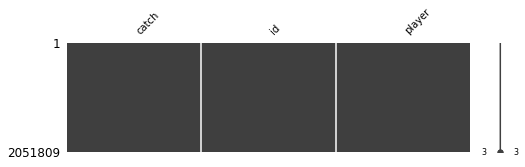

course_meta


courses


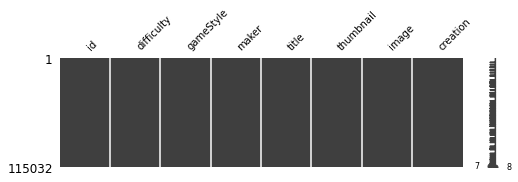

likes


players


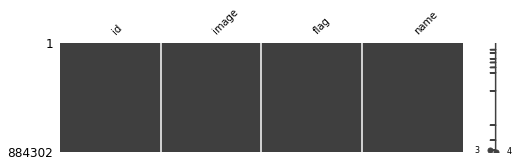

plays


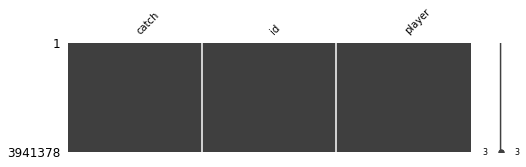

records


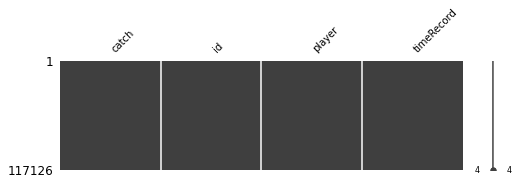

In [11]:
for name, df in dfs.items():
    print(name)
    msno.matrix(df, figsize=(8,2), fontsize=10)
    plt.show()

## Vergleich mit der Realität

Da es sich bei diesem Datensatz hauptsächlich um generierte Daten für ein Spiel handelt, ist eine plausibilisierung relativ schwierig. Nichtsdestotrotz werden hier einige Attribute auf deren Unmöglichkeit untersucht:<br><br>

**Courses Maker**

Alle Levelersteller müssen in `Players` vorkommen, ansonsten sind die Daten nicht vollständig oder fehlerhaft.

In [12]:
unknown_courses = courses[~courses['maker'].isin(players['id'])]
unknown_courses

id difficulty   gameStyle maker  \
4616    D631-0000-034F-099E     expert  marioBrosU   NaN   
6972    90A7-0000-032E-B990     expert   marioBros   NaN   
9465    4BDC-0000-035B-0908     normal   marioBros   NaN   
9735    C1FC-0000-0330-2488     expert   marioBros   NaN   
12192   4DAB-0000-0320-F672     normal   marioBros   NaN   
...                     ...        ...         ...   ...   
108981  8659-0000-0320-CF83       easy  marioBrosU   NaN   
110898  DE15-0000-0368-3851     normal  marioBrosU   NaN   
111621  CAC3-0000-0368-38D9       easy  marioBrosU   NaN   
113297  8764-0000-0368-38C2       easy  marioBrosU   NaN   
113779  E85F-0000-0348-02FE     expert   marioBros   NaN   

                                 title  \
4616                           warfare   
6972                            ®▲ή$0м   
9465          Toilet Duck: Royal Flush   
9735      Panic Pigeon: Muncher Mayhem   
12192                        Bad Kitty   
...                                ...   
108981           WORLD 1-1 (Keep Run)    
110898                Die Schienenwelt   
111621  table tennis mario vs computer   
113297                    DasZaubertal   
113779                           Au Au   

                                                thumbnail  \
4616    https://dypqnhofrd2x2.cloudfront.net/D631-0000...   
6972    https://dypqnhofrd2x2.cloudfront.net/90A7-0000...   
9465    https://dypqnhofrd2x2.cloudfront.net/4BDC-0000...   
9735    https://dypqnhofrd2x2.cloudfront.net/C1FC-0000...   
12192   https://dypqnhofrd2x2.cloudfront.net/4DAB-0000...   
...                                                   ...   
108981  https://dypqnhofrd2x2.cloudfront.net/8659-0000...   
110898  https://dypqnhofrd2x2.cloudfront.net/DE15-0000...   
111621  https://dypqnhofrd2x2.cloudfront.net/CAC3-0000...   
113297  https://dypqnhofrd2x2.cloudfront.net/8764-0000...   
113779  https://dypqnhofrd2x2.cloudfront.net/E85F-0000...   

                                                    image             creation  
4616    https://dypqnhofrd2x2.cloudfront.net/D631-0000...  2017-08-06 00:00:00  
6972    https://dypqnhofrd2x2.cloudfront.net/90A7-0000...  2017-05-14 00:00:00  
9465    https://dypqnhofrd2x2.cloudfront.net/4BDC-0000...  2017-09-05 00:00:00  
9735    https://dypqnhofrd2x2.cloudfront.net/C1FC-0000...  2017-05-20 00:00:00  
12192   https://dypqnhofrd2x2.cloudfront.net/4DAB-0000...  2017-04-13 00:00:00  
...                                                   ...                  ...  
108981  https://dypqnhofrd2x2.cloudfront.net/8659-0000...  2017-04-12 00:00:00  
110898  https://dypqnhofrd2x2.cloudfront.net/DE15-0000...  2017-10-19 23:00:00  
111621  https://dypqnhofrd2x2.cloudfront.net/CAC3-0000...  2017-10-19 23:00:00  
113297  https://dypqnhofrd2x2.cloudfront.net/8764-0000...  2017-10-19 23:00:00  
113779  https://dypqnhofrd2x2.cloudfront.net/E85F-0000...  2017-07-21 00:00:00  

[76 rows x 8 columns]

In [13]:
unknown_courses['maker'].unique()

array([nan], dtype=object)

Wir haben hier 76 Levels, welche keinem Player zugeordnet werden konnten. Es könnte sein, dass diese Accounts der Spieler zum Zeitpunkt der Datensammlung nicht mehr vorhanden waren, oder die Eingabevalidierung von SMM ungenügend ist. Trotzdem haben wir hier keinen Validen Namen in `courses` als Ersteller, welcher nicht in den Accounts der Players vorkommt, was die Plausibilität der Daten bestätigt.<br><br>

**FirstClear**

Die gleiche Untersuchung machen wir nun mit *firstClear* in `course_meta`. Da wenn der Kurs noch nicht beendet wurde, einen NaN Wert aufweist, werden diese erst gefiltert. Ansonsten müssen alle Namen in *firstClear* auch unter den Players sein.

In [14]:
course_meta_filtered = course_meta.dropna(subset=['firstClear'])
unknown_firstClear = course_meta_filtered[~course_meta_filtered['firstClear'].isin(players['id'])]
unknown_firstClear

Empty DataFrame
Columns: [catch, id, firstClear, tag, stars, players, tweets, clears, attempts, clearRate]
Index: []

Auch hier haben wir keine Namen in *firstClear*, welche nicht unter den Playernamen auftauchen. Dies bestätigt die Plausibilität dieses Attributes.<br><br>

**Unmögliche Werte**

Nun schauen wir, dass keine eindeutigen numerischen Fehler auftauchen. Dies betrifft folgende Attribute: `records` *timeRecord* > 0, `course_meta` *clearRate* $\geq$ 0, *attempts* $\geq$ 0, *clears* $\geq$ 0, *stars* $\geq$ 0.

In [15]:
records[records['timeRecord'] <= 0]

Empty DataFrame
Columns: [catch, id, player, timeRecord]
Index: []

In [16]:
imp_features = ['clearRate','attempts','clears','stars']
for feature in imp_features:
    failures = course_meta[course_meta[feature] < 0].shape[0]
    print('Feature ', feature, ' has ', failures, ' incorrect values')

Feature  clearRate  has  0  incorrect values
Feature  attempts  has  0  incorrect values
Feature  clears  has  0  incorrect values
Feature  stars  has  0  incorrect values


Die oben beschriebenen Attribute haben soweit beurteilbar keine unmöglichen Werte.<br><br>

**Plausibilität des Datensatzes**

Der Datensatz scheint soweit beurteilbar der Realität zu entsprechen. Alle gemachten Plausibilitätstest waren erfolgreich. Daher können wir guten Gewissens die Analyse auf dem Datensatz vornehmen.

## Preprocessing Funktion

Die oberhalb erwähnten Plausibilitätstests wurden in eine Preprocessing Funktion integriert. Neben dem Plausibilitätstest durch mehrere `assert`-statements, testet die Funktion für den korrekten Datentyp der DataFrames, beseitigt Datenfehler, wo zum Beispiel `courses > 0` aber `firstclear = NaN` ist, und entfernt Einträge mit fehlenden Werten basierend auf den zwingend notwendigen Informationen die eine Observation eines Datensatzes benötigt..  

In [17]:
def preprocessing(dfs, drop=False, fill=True):
    '''Preprocessing function for Super Mario Maker Dataset.
    - Changes datatypes where necessary
    - Runs multiple asserts to check if quantity/quality of data is correct
    - Deals with missing firstClear values
    - Corrects "clears"-Values where necessary
    - Deals with missing values

    Arguments
    ---------
    dfs: dict, Dictionary of DataFrames (Super Mario Maker DataFrames from Kaggle)
    drop: bool, Removes rows or courses if deemed defect, default False
    fill: bool, Fills firstClear Values if clear can be found in clears-df else sets clears to 0, default True

    Returns
    -------
    dfs : returns dictionary of dataframes
    '''

    # multiple asserts
    assert len(players) >= 880_000, "Number of players is less than expected"
    assert len(courses) >= 115_000, "Number of courses is less than expected"
    assert (course_meta.attempts >= course_meta.clears).all(), "At least one occurance of clears > attempts detected"
    assert len(players) == len(players.id.unique()), "Player id not unique"
    assert len(courses) == len(courses.id.unique()), "Course id not unique"

    # add correct dtype to timestamps, and assert values
    for name, df in dfs.items():
        if "catch" in df.columns:
            df.catch = pd.to_datetime(df.catch)
            assert df.catch.between("2017-11-15","2018-04-11").all(), f"Detected catch timestamp out of range '2017-11-16' - '2018-04-10' in df {name}"
        elif "creation" in df.columns:
            df.creation = pd.to_datetime(df.creation)
            assert (df.creation <= "2018-04-10").all(), f"Detected creation date more recent than 2018-04-10 in df {name}"

        # test for negative numbers in numeric variables
        numerics = ['int64', 'float64']
        num_cols = df.select_dtypes(include=numerics).columns
        for col in num_cols:
            assert (df[col].values >= 0).all(), f"At least one occurance of negative values detected in df {name}"

        # test if id is in allowed format
        r = re.compile("[A-Z|0-9]{4}-[A-Z|0-9]{4}-[A-Z|0-9]{4}-[A-Z|0-9]{4}")
        if "id" in df.columns and name != "players":
            assert df.id.str.fullmatch("[A-Z|0-9]{4}-[A-Z|0-9]{4}-[A-Z|0-9]{4}-[A-Z|0-9]{4}").all(), f"At least one id in wrong format detected in df {name}"

    # sort course_meta and only keep most recent
    course_meta_sort = course_meta.sort_values(by="catch",ascending=False)
    course_meta_uniq = course_meta_sort.groupby(by="id").first().reset_index()
    dfs['course_meta'] = course_meta_uniq
    
    if fill:
        # drop courses with clears > 0 and fistclear == NaN
        invalid_courses = course_meta[(course_meta.clears != 0) & (course_meta.firstClear.isna())]
        # sort by catch, ascending, get first player for every id and import it into courses_meta
        candidate_firstClear = clears[clears.id.isin(list(invalid_courses.id.values))]
        candidate_clean = candidate_firstClear.sort_values(by="catch", ascending=True).groupby(by='id').first().reset_index()

        def func(row):
            if row.id in (candidate_clean.id.values): 
                return candidate_clean[candidate_clean.id == row.id].player

        course_meta['firstClear'] = course_meta.apply(lambda x: func(x), axis=1)

        # set clears to 0 for courses that still have no first clear
        course_meta.loc[(course_meta.clears != 0) & (course_meta.firstClear.isna()), "clears"] = 0
        
        # check if clears == 0 than firstClear == NaN
        assert ((course_meta.clears == 0) & (course_meta.firstClear.isna())).any(), 'Detected courses with clears > 0 and firstClear = NaN'
        
        # check if sum clears == 0 = firstClear == NaN
        assert (len(course_meta.clears == 0) == len(course_meta.firstClear.isna())), 'Missing values in firstClear collumn do not correspond with clears collumn'
    
    if drop: 
        # drop courses with firstClear NaN and clears > 0 (df course_meta)
        course_meta.drop(course_meta[(course_meta.clears != 0) & (course_meta.firstClear.isna())].index, inplace=True)
        # drop courses with maker NaN (df courses)
        courses.drop(courses[courses.maker.isna()].index, inplace=True)
        # drop players with no name (df players)
        players.drop(players[players.name.isna()].index, inplace=True)
        # drop courses where title is NaN
        courses.drop(courses[courses.title.isna()].index, inplace=True)
            
    return dfs

dfs = preprocessing(dfs, drop=True, fill=True)    

# EDA

In [18]:
# helper funktion
def plot_wrapper(plot_object, title, subtitle, xlabel, ylabel, xtick_rotation = None):
    """
    Simple function to set title, labels etc. of a seaborn plot. Helps with readability.
    The function prints the plot.
    
    Arguments
    ---------
    :param plot_object:    a seaborn plot object
    :param title:          str, sets a bold title
    :param subtitle:       str, sets a subtitle
    :param xlabel:         str, replaces xlabel
    :param ylabel:         str, replaces ylabel
    :param xtich_rotation: int, rotates xticks  
    
    Returns
    -------
    :return None:          the function prints a plot
    """
    g = plot_object

    # Title, Subtitle and Axis
    if subtitle is not None:
        g.text(x=0.5, 
                y=1.06, 
                s=title, 
                fontsize=10, weight='bold', ha='center', va='bottom', transform=g.transAxes)
        g.text(x=0.5, 
                y=1.01, 
                s=subtitle, 
                fontsize=10, alpha=0.75, ha='center', va='bottom', transform=g.transAxes)
    elif subtitle is None:
        g.text(x=0.5, 
                y=1.01, 
                s=title, 
                fontsize=10, weight='bold', ha='center', va='bottom', transform=g.transAxes)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xtick_rotation is not None:
        plt.xticks(rotation=xtick_rotation)
    plt.show()

## Wie sieht die Schwierigkeitsverteilung der kreierten Levels aus?

In [19]:
def level_difficilties(courses):
    '''Visualizes the number of levels created by each difficulty'''
    course_difficulties = courses.groupby("difficulty").count()
    colors = ["#2CB01A","#FBD000", "#FF1E2d", "#000000"]
    plt.bar(x=["easy", "normal", "expert", "superExpert"], height=course_difficulties["id"], color = colors)
    plt.title("Nr of Levels by Difficulty")
    plt.xlabel("Difficulty")
    plt.ylabel("count [n]")
    plt.show()
    
level_difficilties(courses)

Die einzelnen Levels können einer von vier ordinalen Schwierigkeitsstufen zugeordnet werden. Die Reihenfolge in aufsteigender Schwierigkeit lautet: easy < normal < expert < superExpert. Die relativen Anteile der Kategorien lauten: Zu 26 Prozent easy, 24 Prozent normal, 45 Prozent expert und zu 5 Prozent superExpert.

### Welche Nationalitäten sind unter den Spielern am häuffigsten vertreten?

In [20]:
def player_nationalities(players, top_n):
    nationalities = players.copy()
    nationalities["count"] = 1
    nationalities = nationalities.groupby("flag").count()["count"].sort_values(ascending=False)
    top_nationalities = nationalities[0:top_n].append(pd.Series(nationalities[top_n:].sum()))
    new_index = list(top_nationalities.index)
    new_index[-1] = "Others"
    top_nationalities.index=new_index

    plt.bar(x=top_nationalities.index, height=top_nationalities, color="#FF1E2D")
    plt.title("Nr of Players by Nationality")
    plt.xlabel("Country")
    plt.ylabel("count [n]")
    plt.show()
    
    return top_nationalities

print("Nationalities:\n" + player_nationalities(players, top_n=10).to_string(dtype=False))

Nationalities:
US        292468
JP        286505
FR         50212
DE         48182
CA         46108
GB         37281
MX         28016
ES         22070
AU          9651
NL          9475
Others     54324


Im Datensatz befinden sich zu je einem Drittel US-Amerikanische und japanische Spieler. Danach folgen Frankreich (5.6 %), Deutschland (5.4 %) und Kanada (5.2 %). Insgesamt enthält der Datensatz 884302 Spielerprofile aus 82 verschiedenen Nationen.

## Verteilung von Timestamps

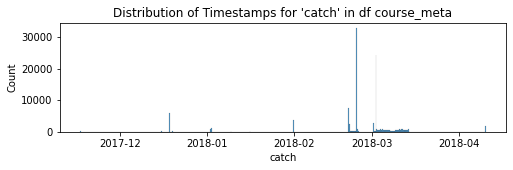

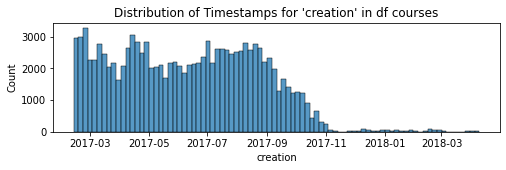

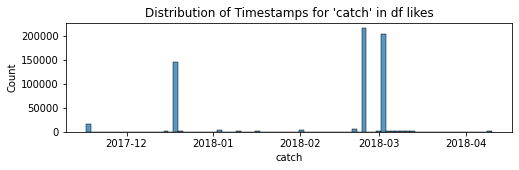

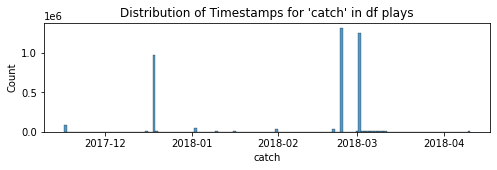

In [21]:
for name, df in dfs.items():
    if "catch" in df.columns:
        col = "catch"
    elif "creation" in df.columns:
        col = "creation"
    else:
        continue
    plt.figure(figsize=(8,2))
    sns.histplot(df[col]).set_title(f"Distribution of Timestamps for '{col}' in df {name}")
    plt.show()

Die obere Grafik zeigt die Verteilung der Spalte `timestamp`. Dabei sind drei markante Ausprägungen in den meisten DataFrames zu erkennen. Wir nehmen an dass diese `timestamp`-Spalten den Zeitpunkt der Datenerhebung markieren und nicht in Zusammenhang mit der erstellung von Levels oder Playern, &c., steht.  Das DataFrame `creation` scheint den Zeitpunkt der erstellung eines Levels festzuhalten wir erkennen gut das nach September 2019 die Zahl stark abnimmt und ab November 2019 bei fast 0 stagniert.

## Diverse Histogramme

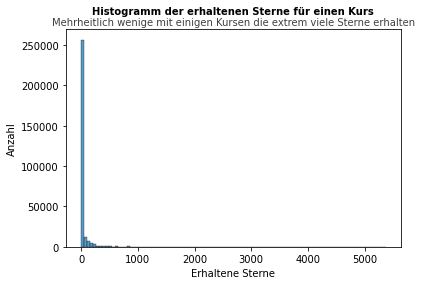

In [22]:
g = sns.histplot(data=course_meta, x='stars',bins=100)
plot_wrapper(g, 'Histogramm der erhaltenen Sterne für einen Kurs', 'Mehrheitlich wenige mit einigen Kursen die extrem viele Sterne erhalten', 'Erhaltene Sterne', 'Anzahl')

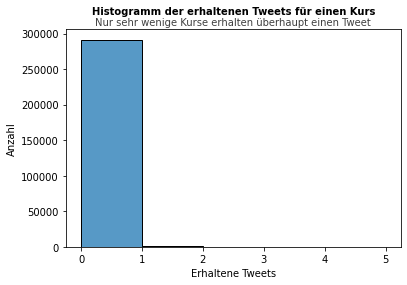

In [23]:
g = sns.histplot(data=course_meta, x='tweets',bins=5)
plot_wrapper(g, 'Histogramm der erhaltenen Tweets für einen Kurs', 'Nur sehr wenige Kurse erhalten überhaupt einen Tweet', 'Erhaltene Tweets', 'Anzahl')

Die Features `tweets` und `stars` geben einen Einblick in die "Beliebtheit" der jeweiligen Kurse. Tweets werden allerdings kaum verwendet und es gibt nur wenige Kurse die viele Sterne erhalten. 

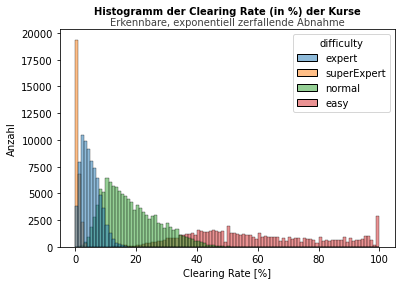

In [24]:
dif_clear = pd.merge(left=course_meta, right=courses, on='id')
g = sns.histplot(data=dif_clear, x='clearRate',bins=100, hue='difficulty')
plot_wrapper(g, 'Histogramm der Clearing Rate (in %) der Kurse', 'Erkennbare, exponentiell zerfallende Abnahme' , 'Clearing Rate [%]', 'Anzahl')

Hier sehen wir das bei den meisten Kursen nur eine geringe Clearing Rate existiert. Dies kann an der Bekanntheit oder dem Schwierigkeitsgrad der Kurse liegen. An den Schwierigkeitsgruppen erkennen wir das die einfachen Kurse "easy" eine hohe Clearing Rate aufweisen. Mit steigendem Schwierigkeitslevel, nimmt die Clearing Rate ab. "SuperExpert" werden zum Beispiel kaum bestanden.

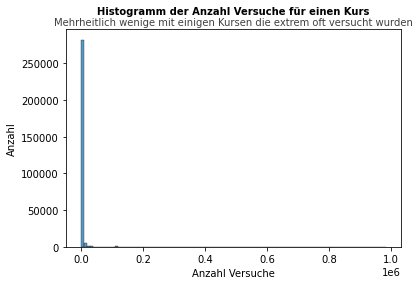

In [25]:
g = sns.histplot(data=course_meta, x='attempts',bins=100)
plot_wrapper(g, 'Histogramm der Anzahl Versuche für einen Kurs', 'Mehrheitlich wenige mit einigen Kursen die extrem oft versucht wurden', 'Anzahl Versuche', 'Anzahl')

Spannend ist hier zu sehen das die meisten Kurse kaum benutzt werden. Während einige wenige sehr oft verwendet werden.

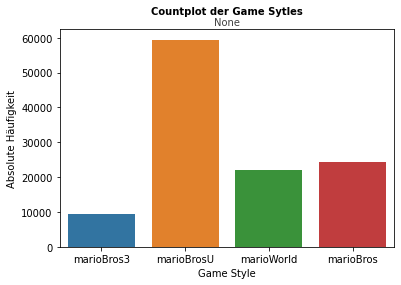

In [26]:
g = sns.countplot(x = courses.gameStyle)
plot_wrapper(g, 'Countplot der Game Sytles','None', 'Game Style', 'Absolute Häufigkeit')

# Social Network Analysis

## Player-Level interaction

Der Hauptgedanke von Super Mario Maker ist zwar das erstellen und teilen von Levels. Die Spieler werden aber nicht dazu gezwungen. Beim Super Mario Maker gibt es zum Start über 100 von Nintendo veröffentlichte Levels, welche zum Spielen bereitstehen. Ausserdem besteht die Möglichkeit, Levels offline zu erstellen und nicht zu veröffentlichen, sodass diese nur von einem selbst gespielt werden. 

Der Datensatz selbst beinhaltet nur Levels, welche auch in der Community veröffentlicht wurden. In diesem Abschnitt möchten wir deshalb untersuchen wie aktiv die Spieler sich in unserem Super Mario Maker Netzwerk verhalten. Dadurch könnten wir dann erahnen, wie viele Personen tatsächlich auch die Community gemachten Levels ausprobieren und ob diese neue Idee vom gegenseitigen erstellen und teilen von Levels seinen Zweck erfüllt. 

Der Datensatz enthält die beiden Tabellen "players", welche alle Spieler enthält und die Tabelle "plays", in der alle Interaktionen dieser Spieler mit einem Level enthalten sind. Mit diesen beiden Tabellen können wir ein two-nodes Netzwerk aller Interaktionen zwischen Spielern und Levels erstellen.

### Create Graph

In einem ersten Schritt erstellen wir hier unserern Netzwerk Graphen.

In [27]:
# merge players df with plays df
player_game_interactions = pd.merge(players, plays.rename(columns={"id": "level_id"}), how="left", left_on="id", right_on="player")

player_level_interactions = nx.Graph()

player_nodes = list(player_game_interactions["id"].unique())
level_nodes = list(player_game_interactions["level_id"].unique())
edges = player_game_interactions[["player", "level_id"]].values.tolist()

player_level_interactions.add_nodes_from(player_nodes)
player_level_interactions.add_nodes_from(level_nodes)
player_level_interactions.add_edges_from(edges)

### Player-Level Graph Information

In [28]:
print("edges count:",len(dict(player_level_interactions.edges())))
print("level_node count:",len(dict(player_level_interactions.degree(level_nodes))))
print("player_node count:",len(dict(player_level_interactions.degree(player_nodes))))
print("Average level_node degree:",np.mean(list(dict(player_level_interactions.degree(level_nodes)).values())))
print("Average player_node degree:",np.mean(list(dict(player_level_interactions.degree(player_nodes)).values())))

edges count: 3941327
level_node count: 115033
player_node count: 884292
Average level_node degree: 34.262585518938046
Average player_node degree: 4.457041339286119


Im Graphen befinden sich insgesamt 884'292 Spieler und 115'033 Level. Diese sind über 3'941'327 Kanten miteinander verbunden. Eine Kante repräsentiert hierbei eine Interaktion zwischen einem Spieler mit einem Level, und existiert so fern dieser das entsprechende Level gespielt hat. Der durchschnittliche Level-Knoten Grad ist 34.26, heisst im Schnitt wurde ein Level von etwas über 34 Spieler angespielt. Der durchschnittliche Spieler hat hingegen nur 4.46 Levels ausprobiert. 

### Visualisierung von 1 Prozent der Spieler

Es ist uns leider nicht möglich, den kompletten Graphen zu visualisieren. Mit Fast einer Million Knoten und vier Millionen Kanten ist unser Netzwerk einfach zu gross. Wir versuchen deshalb, als nächstes zufällige 1 Prozent aller Spieler inklusive deren Level-Interaktionen darzustellen.

In [29]:
def random_n_players(players, plays, n):
    #merge players df with plays df
    player_game_interactions = pd.merge(players, plays.rename(columns={"id": "level_id"}), how="left", left_on="id", right_on="player")
    # Filter for random n players
    n_random_players = random.sample(set(player_game_interactions["player"]), n)
    n_player_interactions = player_game_interactions.loc[player_game_interactions['player'].isin(n_random_players)].reset_index(drop=True)
    return n_player_interactions

n_player_interactions = random_n_players(players, plays, int(len(players)/100))

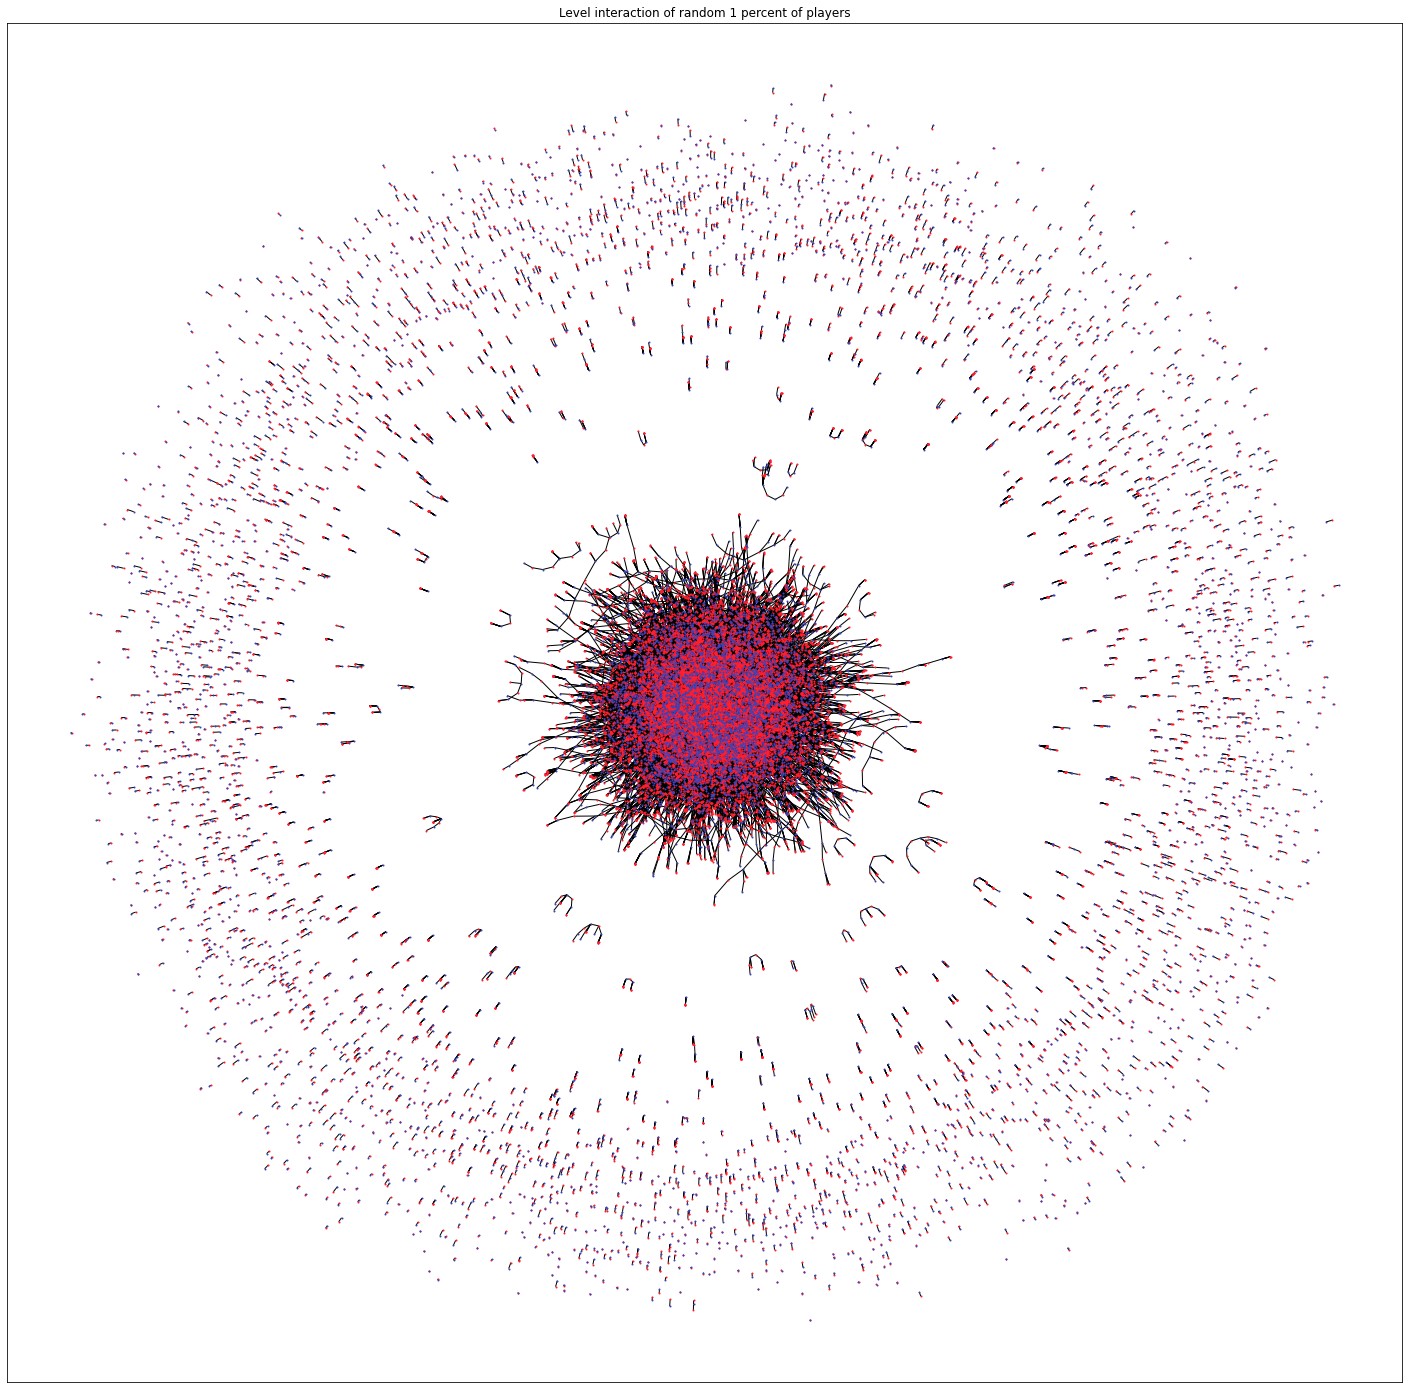

In [30]:
random_n = nx.Graph()

player_nodes = list(n_player_interactions["player"].unique())
level_nodes = list(n_player_interactions["level_id"].unique())
edges = n_player_interactions[["player", "level_id"]].values.tolist()

random_n.add_nodes_from(player_nodes)
random_n.add_nodes_from(level_nodes)
random_n.add_edges_from(edges)

pos = nx.drawing.layout.spring_layout(random_n, seed=98)

plt.figure(figsize=(25, 25))
ax = plt.gca()
ax.set_title('Level interaction of random 1 percent of players')

nx.draw_networkx_nodes(random_n, pos, nodelist=level_nodes, node_color="#FF1E2D", node_size=1)  
nx.draw_networkx_nodes(random_n, pos, nodelist=player_nodes, node_color="#3944BC", node_size=1)                                                                                                        
                                                                                                      
nx.draw_networkx_edges(random_n, pos)

plt.savefig('./images/Level interaction of random 1 percent of players.png', dpi=800, format="png")
plt.draw()
plt.show()

Die Visualisierung zeigt gut ein Prozent aller Spieler und aller ihrer Level-Intertaktionen. Die Blauen Knoten Repräsentieren Spieler und die Roten Knoten sind Levels. Wir erkennen einen riesigen "Giant"-Komponenten in der Mitte. Es war uns leoder nicht möglich ein Layout zu finden, welches mit angemessenem Rechenaufwand ein übersichtlicheres Layout erreicht hat. Rundherum sammeln sich einzene Spieler, welche häufig nur mit einem oder zwei anderen Levels interagiert haben. Der Graph dient hier nur zur Visualisierung, weshalb wir auf eine genauere Untersuchung des Teil-Netzwerkes verzichten und uns in der weiteren Analyse wieder auf das Komplette Netzwerk beziehen.

### Player-Level Interactions Distribution

In einem nächsten Schritt wollen wir untersuchen, wie sich Spieler des gesammten Player-Level Netzwerkes, in Bezug zu ihrer totalen Anzahl an gespielten Levels verteilen.

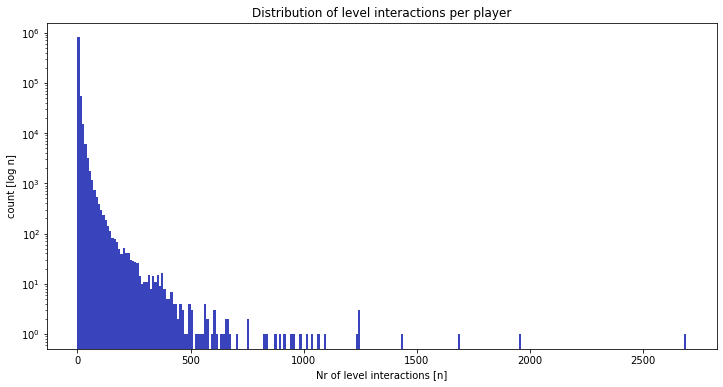

Quantiles:
0.00       0.0
0.25       1.0
0.50       2.0
0.75       4.0
1.00    2681.0


In [31]:
def plot_player_degrees_pd(player_game_interactions):
    '''Calculates node degrees and viszalizes them using a histogramm'''
    data = player_game_interactions.groupby("id").count().reset_index().rename(columns={"player": "interactions"})

    plt.figure(figsize=(12, 6))
    plt.hist(data["interactions"], bins=range(min(data["interactions"]), max(data["interactions"]) + 10, 10), color="#3944BC")
    plt.yscale('log')
    plt.title("Distribution of level interactions per player")
    plt.xlabel("Nr of level interactions [n]")
    plt.ylabel("count [log n]")
    plt.show()
    return data.drop(columns=["image","flag","name","catch","level_id"]).sort_values("interactions", ascending=False).reset_index(drop=True)
    
node_degrees = plot_player_degrees_pd(player_game_interactions)
print("Quantiles:")
print((node_degrees["interactions"].quantile([0,0.25,0.5,0.75,1])).to_string(dtype=False))

Das Histogramm zeigt die Verteilung der Summe an Levelinteraktionen pro Spieler. Obwohl das arithmetische Mittel der Anzahl an gespielten Levels pro Spieler bei 4.45 liegt, sind über 75 Prozent aller Spieler unter diesem Wert. Das liegt vor allem daran, dass es einen kleinen Teil an sehr aktiven Spielern im Datensatz gibt. Der überwiegende Teil der Spieler hat gar keine oder nur sehr wenige Levels gespielt. Der Spieler mit den meisten gespielten Levels hat sogar ganze 2681 Interaktionen. Da es scheinbar einen kleinen Anteil an sehr aktiven Spielern im Datensatz gibt, wollen wir diese nun etwas genauer unter die Lupe nehmen.

#### Diverse Netzwerkmetriken

**Graph Density**  Diese Metrik beschreibt wie stark Nodes im Graph untereinander verbunden sind. Ein Wert von $0.00000789$ indiziert das Nodes nur schwach, bzw. zu wenig anderen verbunden sind. Ein Score von $1$ würde bedeuten das alle Nodes mit allen anderen Nodes verbunden wären.

In [32]:
nx.density(player_level_interactions)

7.893314265853868e-06

**Diameter** Der Durchmesser beschreibt den längsten, kürzesten Pfad. Da es mehrere Komponenten gibt ist diese Metrik nicht definiert, bzw ist gleich $\infty$.

In [33]:
# nx.diameter(player_level_interactions)

**Cluster Coefficient** Der Cluster Coefficient wird aus der Anzahl direkter Kantein zwichen Nachbaren eines Nodes und der maximalen Anzhal an Kanten berechnet. Der Score weist darauf hin das es kaum starke Vernetzungen gibt.

In [34]:
nx.average_clustering(player_level_interactions)

0.0

### Top Players

Wir möchten nun die aktivsten Spieler im Datensatz noch etwas genauer untersuchen. Als Erstes wollen wir herausfinden, für wie viel Level-Interaktionen die aktivsten 10 Prozent der Spieler im Datensatz verantwortlich sind.

#### Top 10 Percent of Players

In [35]:
levels_by_top_10p_of_players = np.sum(node_degrees.loc[0:round(len(node_degrees)/10)]["interactions"])
print("\nMin levels required to be top 10 percent:", node_degrees["interactions"].quantile(0.9))
print("\nNr of levels played by top 10 percent most active players:",levels_by_top_10p_of_players)
print("\nProportion of levels played by top 10 percent most active players:",levels_by_top_10p_of_players/len(dict(player_level_interactions.edges())))


Min levels required to be top 10 percent: 9.0

Nr of levels played by top 10 percent most active players: 2088726

Proportion of levels played by top 10 percent most active players: 0.529955012613772


Die aktivsten 10 Prozent der Spieler haben total 208'8755-mal ein neues Level angespielt. Sie sind also für rund 53 Prozent aller Spielaktivität im Netzwerk verantwortlich. Um zu diesem Teil dazuzugehören müssen 9 oder mehr unterschiedliche Levels gespielt worden sein.

#### Top 1 Percent of Players

In [36]:
levels_by_top_1p_of_players = np.sum(node_degrees.loc[0:round(len(node_degrees)/100)]["interactions"])
print("\nMin levels required to be top 1 percent:", node_degrees["interactions"].quantile(0.99))
print("\nNr of levels played by top 1 percent most active players:",levels_by_top_1p_of_players)
print("\nProportion of levels played by top 1 percent most active players:",levels_by_top_1p_of_players/len(dict(player_level_interactions.edges())))


Min levels required to be top 1 percent: 41.0

Nr of levels played by top 1 percent most active players: 747903

Proportion of levels played by top 1 percent most active players: 0.18975918516783813


Die aktivsten 1 Prozent der Spieler sind mit 747903 gespielten Levels noch für rund 19 Prozent der Spieleaktivitäten verantwortlich. Um zu den Top 1 Prozent zu gehören müssen minsestens 41 verschiedene Levels gespielt werden.

#### People that don't have a real live

In [37]:
cummulative_plays = node_degrees.iloc[0:100].cumsum()
print("Players to reach 1 % of plays:",len(cummulative_plays.loc[cummulative_plays["interactions"] <= len(dict(player_level_interactions.edges()))/100].index)+ 1)
print("Levels played by these players:",node_degrees.loc[0:44]["interactions"].sum())

Players to reach 1 % of plays: 45
Levels played by these players: 39537


In [38]:
print("Players with > 1000 level-interactions:\n")
print(node_degrees.loc[node_degrees["interactions"]>=1000])
print("\nProportion of played levels:", node_degrees.loc[node_degrees["interactions"]>=1000]["interactions"].sum()/3941379)

Players with > 1000 level-interactions:

                  id  interactions
0    Conducteur59220          2681
1           dellbox2          1951
2            AE4WiiU          1686
3           revolv23          1437
4   demonhunter47223          1246
5       WIIMoustique          1244
6   buddy1943indiana          1242
7    Plusbellelavie5          1234
8      Feuxdelamoule          1096
9         cowboye123          1068
10     quentintheret          1035
11          Tylano64          1010

Proportion of played levels: 0.004295450906903396


Die 45 Personen, welche am meisten Levels gespielt haben erreichen gut  345353 aller Level-Interaktionen oder 1 Prozent der Interaktionen im gesamten Datensatz. Von diesen erreichen 12 Spieler sogar mehr als 1000 gespielte Levels.

### Zusammenfassung

Aufgrund unserer Auswertung wissen wir nun, dass über 75 Prozent der Spieler mindestens 1 Community gemachtes Level ausprobiert haben. Es ist aber auch erkennbar, dass die meisten Spieler nicht nachhaltig aktiv bleiben und weniger als 10 Prozent 10 unterschiedliche Levels gespielt haben. Trotzdem scheint das Konzept aufseiten der Spieler zu funktionieren, was daran erkennbar ist, dass sich eine kleine Kerngruppe herausgebildet hat, welche das Netzwerk sehr aktiv zu nutzen scheint. 

## Likes Network

Gefällt einem Spieler ein Level, dann kann er dieses mit einem Stern kennzeichnen. Sterne können dementsprechend als Likes verstanden werden und können uns einiges über die Interessen der einzelnen Spieler aussagen.
In diesem Abschnitt möchten wir das Like-Verhalten der Spieler im Datensatz etwas genauer untersuchen. Die dafür verwendeten Daten stammen aus dem "likes.csv" und dem "players.csv". 

Anschliessend möchten wir das Like-Verhalten der Spieler miteinander Vergleichen und so für einzelne Spieler Accounts mit ähnlichen Interessen finden. Wir wollen diese dann nutzen, um mögliche neue Levels zu finden, welche die ähnlichen Spieler mögen, um diese dann zu empfehlen.

### Overview

In [39]:
print("Likes Table:\nNr. of likes: " + str(len(likes)) + "\nNr. of players: " + str(len(likes["player"].unique())))

Likes Table:
Nr. of likes: 618687
Nr. of players: 181888


In unserem Datensatz befinden sich insgesammt 618'687 Likes von 181'888 unterschiedlichen Spielern.

In [40]:
player_likes = likes[["player","id"]].groupby("player").count().reset_index().rename(columns={"id":"levelsLiked"})
player_likes = pd.merge(players, player_likes, how="left", left_on="id", right_on="player").drop(columns="player")
player_likes["levelsLiked"] = player_likes["levelsLiked"].fillna(0)

rating_player_ratio = len(player_likes.loc[player_likes["levelsLiked"]!=0]) / len(player_likes)
print("Has rated: " + str(round(rating_player_ratio*100, 2)) + "%")
print("Not rated: " + str(100-round(rating_player_ratio*100, 2)) + "%")

Has rated: 20.57%
Not rated: 79.43%


Von allen Spielern im Datensatz haben 20,6 Prozent (Jeder 5te Spieler) mindestens ein Level bewertet. Entsprechend hinterlässt die Mehrheit der Spieler, 80 Prozent keine Bewertungen. Um ein genaueres Bild der Verteilung der Anzahl an Likes aller Spieler im "Likes Netzwerk" zu erhalten werden diese im Nächsten Schritt als Histogramm angezeigt.

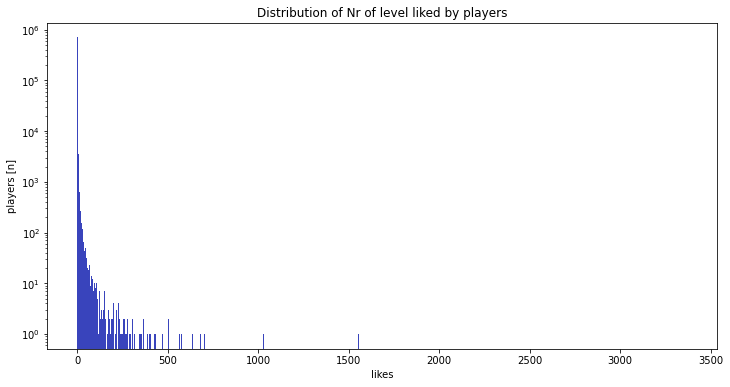

Quantiles:
0.000       0.0
0.250       0.0
0.500       0.0
0.750       0.0
0.800       1.0
0.900       1.0
0.950       2.0
0.990       8.0
0.999      71.0
1.000    3365.0
Name: levelsLiked, dtype: float64


In [41]:
plt.figure(figsize=(12, 6))
plt.hist(player_likes["levelsLiked"], bins=range(int(min(player_likes["levelsLiked"])), int(max(player_likes["levelsLiked"])) + 1, 1),color="#3944BC")
plt.yscale('log')
plt.title("Distribution of Nr of level liked by players")
plt.xlabel("likes")
plt.ylabel("players [n]")
plt.show()

print("Quantiles:")
print(player_likes["levelsLiked"].quantile([0,0.25,0.5,0.75,0.8,0.9,0.95,0.99,0.999,1]))

Wenn wir das Histogramm betrachten, dann sehen wir die Verteilung der Anzahl an Levelbewertungen pro Spieler. Wir erkennen nun noch deutlicher, dass ein grosser Teil keine oder nur wenige Likes abgegeben hat. Es gibt jedoch einen sehr kleinen Anteil an Spielern welche sehr viel Bewertet haben. Der Spieler mit den meisten Likes hat insgesamt 3365 Levels "geliked". Diese Zahl ist grösser wir die maximale Anzahl an gespielten Levels und kann dadurch erklärt werden, dass ein Level nicht gespielt werden muss, damit der Spieler ein Like hinterlassen kann. Als Nächstes möchten wir das Like-Netzwerk als Graph generieren.

### Pre-Filtering

Aus Gründen der Übersichtlichkeit und Effizienz werden für das weitere Vorgehen Spieler mit nur wenigen Likes herausgefiltert.

In [42]:
def minimal_likes(df, n):
    # input: Likes table
    # output Likes table with only players having at least n likes
    min_likes = df.groupby("player").count().rename(columns={"catch": "likes"}).drop(columns="id")
    min_likes = min_likes.loc[min_likes["likes"] >= n].sort_values("likes").index.tolist()
    df = df.loc[df["player"].isin(min_likes)].sort_values("player").reset_index(drop=True)
    return df

likes_50 = minimal_likes(likes, 50)

### Graph generation

In [43]:
def generate_bi_graph(df, nodes_1, nodes_2):
    '''Generates a two node network'''
    G = nx.Graph()
    
    n_1 = list(df[nodes_1].unique())
    n_2 = list(df[nodes_2].unique())
    edges = df[[nodes_1, nodes_2]].values.tolist()
    
    G.add_nodes_from(n_1)
    G.add_nodes_from(n_2)
    G.add_edges_from(edges)
    return G, n_1, n_2


G_likes, player_nodes, level_nodes = generate_bi_graph(likes_50, "player", "id")

plr, lvl = bipartite.sets(G_likes)
print("Nr of Players (nodes):", len(plr))
print("Nr of Levels (nodes):", len(lvl))
print("Nr of likes (edges)", len(G_likes.edges))

Nr of Players (nodes): 1326
Nr of Levels (nodes): 51346
Nr of likes (edges) 210842


Der two-nodes Graph "G_likes" besteht aus insgesamt 1326 Spieler welche 210'842 Likes bei 51'346 verschiedene Levels hinterlegt haben. In einem nächsten schritt wird dieser Graph in ein one-mode Netzwerk umgewandelt, wobei die Knoten die einzelnen Spieler repräsentieren. 

Die Kantengewichte zwischen zwei Spielern beschreiben das Verhältnis der Levels welche von beiden Knoten gemeinsam geliked wurden, errechnet mit dem Jaccard-Index: $$w_{u,v} = \frac{N(u)\cap N(u)}{N(u)\cup N(u)}$$

In [45]:
if not os.path.isfile("./data/pickle/G_similar_likes.gpickle"):
    # Transform to one node network
    G_similar_likes = bipartite.overlap_weighted_projected_graph(G_likes, player_nodes) #overlap using jaccard coefficient of neighborhoods
    # Save as pickle
    nx.write_gpickle(G_similar_likes, "./data/pickle/G_similar_likes.gpickle") 
else:
    # Load file
    G_similar_likes = nx.read_gpickle("./data/pickle/G_similar_likes.gpickle")

print("Nr of Players (nodes):", len(G_similar_likes.nodes))
print("Nr of similarities (edges)", len(G_similar_likes.edges))

Nr of Players (nodes): 1326
Nr of similarities (edges) 338304


Das transformierte one-node Netzwerk hat nach wie vor 1326 Spieler. Zwischen den Spielern bestehen neu 338304 Kanten, welche die Ähnlichkeit zwischen den "gelikten" Levels zweier Spieler repräsentieren. Damit eine Kante zwischen 2 Spielern existiert muss mindestens eine gemeinsame positive Bewertung vorhanden sein.

### Filter for players with similarities > 0.2

Da wir nach Spielern mit gemeinsamen Interessen suchen macht es Sinn, Kannten unter einem gewissen Schwellenwert zu eliminieren, da diese Spieler eine zu kleine Gemeinsamkeit zueinander haben. Wir definieren diesen Schwellenwert hier auf 0.2 = mind. 20 Prozent der Levels welche Zwei Spieler geliked haben müssen gleich sein, ansonsten gelten sie nicht als ähnlich und die Kante wird eliminiert. Dadurch erhalten wir den folgenden Graph:

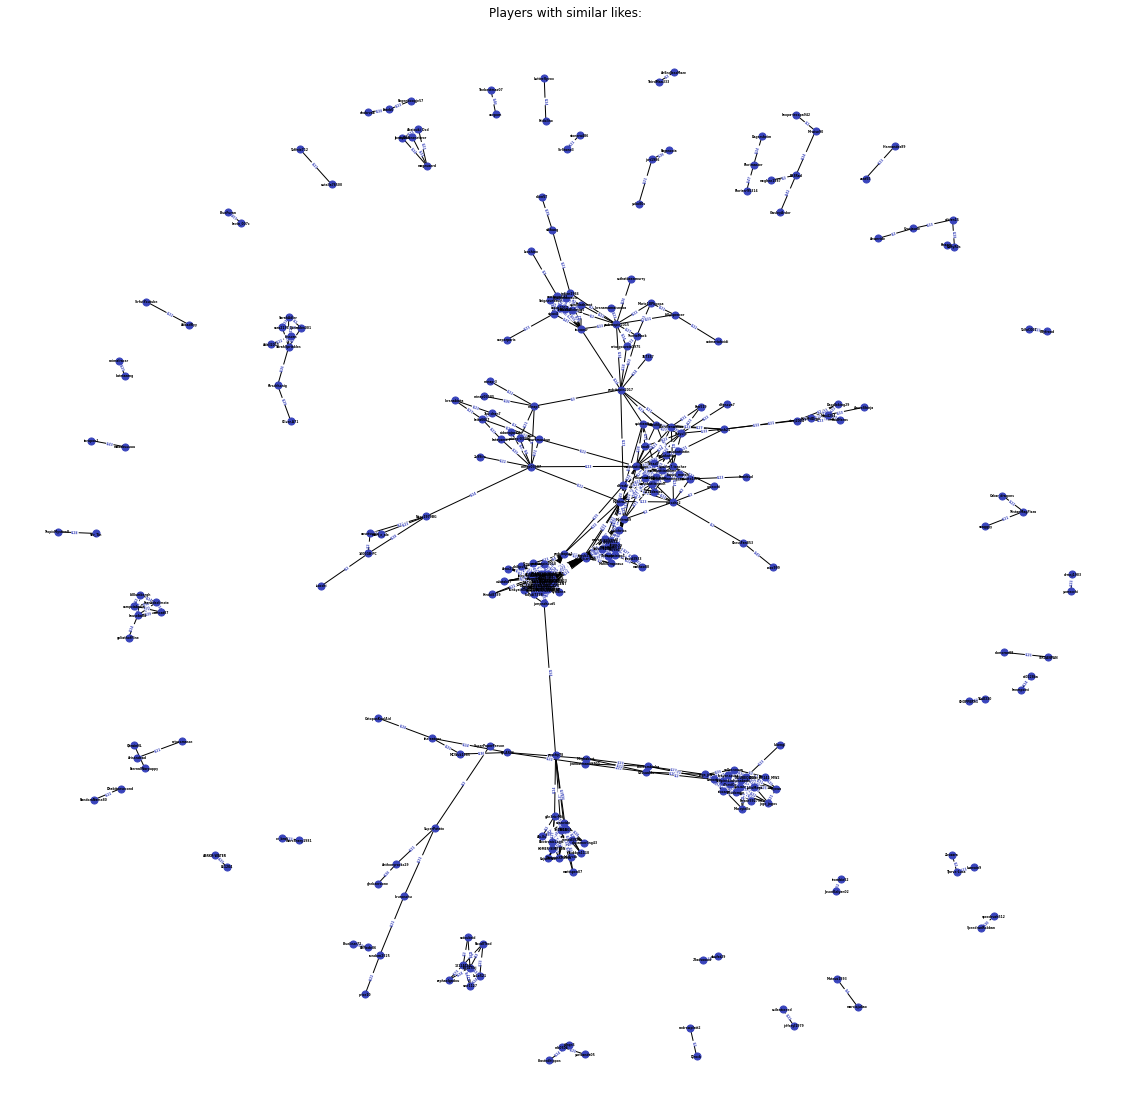

In [46]:
# Load grahp
G_similar_likes = nx.read_gpickle("./data/pickle/G_similar_likes.gpickle")

# remove edges with edge weight < 0.2
edge_weights = nx.get_edge_attributes(G_similar_likes,'weight')
G_similar_likes.remove_edges_from((e for e, w in edge_weights.items() if w <0.2))

# remove isolated nodes
G_similar_likes.remove_nodes_from(list(nx.isolates(G_similar_likes))) 

# Create edge labels
edge_labels=dict([((u,v,),round(d['weight'],2)) for u,v,d in G_similar_likes.edges(data=True)])

# Draw graph
plt.figure(figsize=(20, 20))
ax = plt.gca()
ax.set_title('Players with similar likes:')
pos = nx.drawing.layout.spring_layout(G_similar_likes, seed=1)
nx.draw(G_similar_likes, pos, with_labels=True, connectionstyle='arc3', node_color = "#3944BC", font_weight='heavy', font_size=3, node_size=50)
nx.draw_networkx_edge_labels(G_similar_likes, 
                             pos, edge_labels=edge_labels, 
                             label_pos=0.55, font_size=3, 
                             font_weight='heavy', 
                             font_color="#3944BC", 
                             bbox=dict(facecolor='white',edgecolor='none',alpha=1, pad=0.0))

plt.draw()
plt.show()

### Visualizing connected components

Wir können dieses Netzwerk nun auf verschiedene Attribute untersuchen. Um dieses noch übersichtlicher darzustellen werden die einzelnen "Connected Components" unterschiedlich eingefärbt.

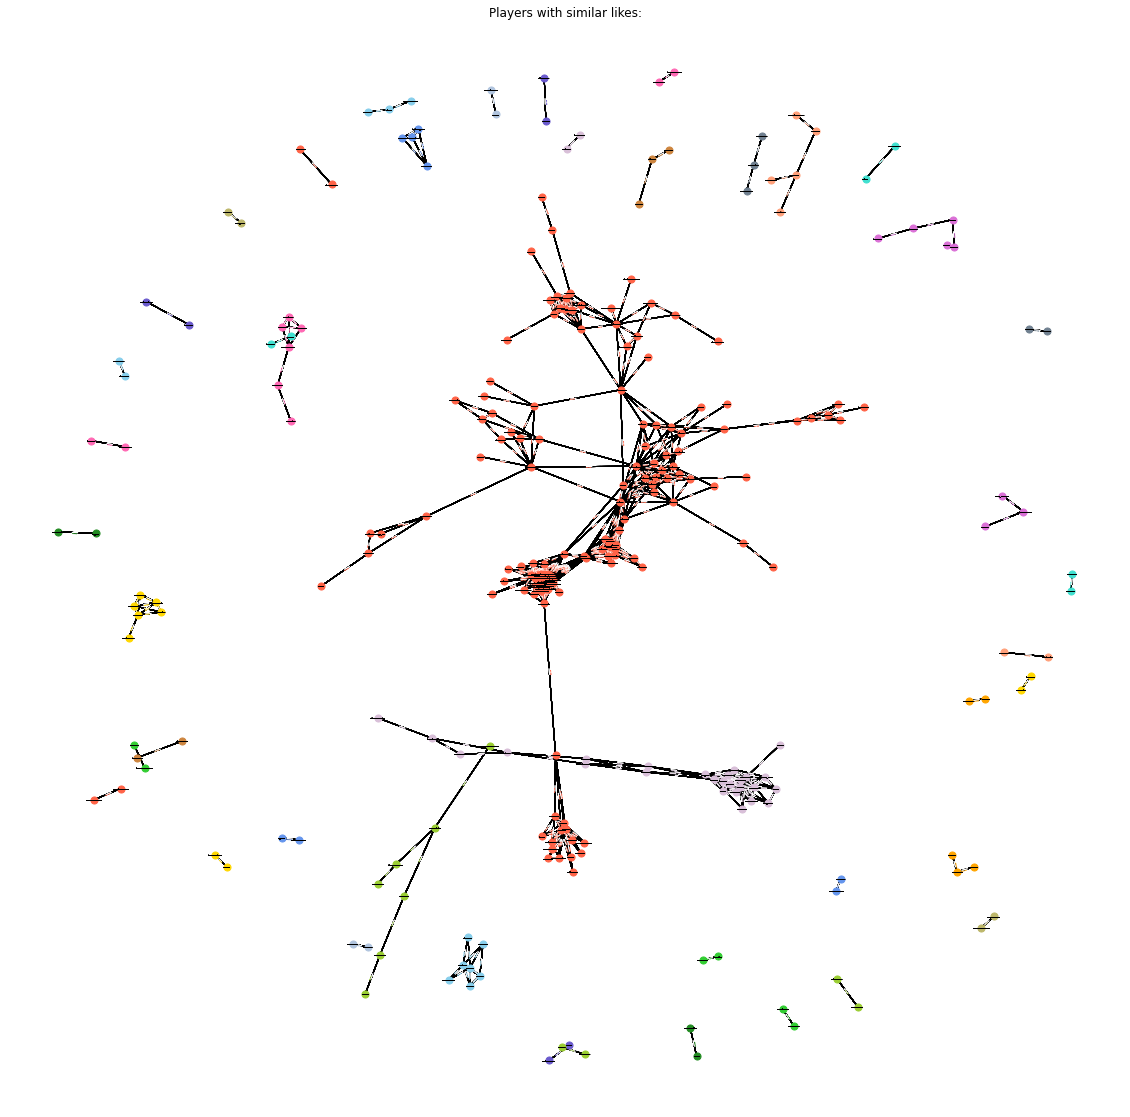

In [47]:
colors = ["tomato","skyblue","limegreen","gold","slateblue","turquoise","cornflowerblue",
          "hotpink","yellowgreen","orchid","peru","lightsalmon","thistle","darkkhaki",
          "lightsteelblue","orange","forestgreen","slategrey"]*round(nx.number_connected_components(G_similar_likes)/18+0.5)

# Draw graph
plt.figure(figsize=(20, 20))
ax = plt.gca()
ax.set_title('Players with similar likes:')
pos = nx.drawing.layout.spring_layout(G_similar_likes, seed=1)
for i, component in enumerate(nx.connected_components(G_similar_likes)):
    nx.draw(G_similar_likes, pos, with_labels=True, nodelist=component, connectionstyle='arc3', node_color=colors[i], font_size=2, node_size=50)
    for j in component:
        edge_labels=dict([((u,v,),round(d['weight'],3)) for u,v,d in G_similar_likes.edges(data=True) if (u == j) or (v == j)])
        nx.draw_networkx_edge_labels(G_similar_likes, 
                             pos, edge_labels=edge_labels, 
                             label_pos=0.55, font_size=2, 
                             font_weight='heavy', 
                             font_color=colors[i], 
                             bbox=dict(facecolor='white',edgecolor='none',alpha=1, pad=0.0))
               
plt.savefig("./images/likes_connected_components.png", dpi=800, format="PNG")


plt.draw()
plt.show()

In [48]:
print("Nr of connected components:", nx.number_connected_components(G_similar_likes))
cpnt = [len(c) for c in sorted(nx.connected_components(G_similar_likes), key=len, reverse=True)]
print("Component sizes:", cpnt)
print("Giant component ratio:", round(cpnt[0]/sum(cpnt),3))

Nr of connected components: 45
Component sizes: [140, 26, 7, 7, 6, 6, 5, 5, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Giant component ratio: 0.495


Das neue, gefilterte Netzwerk besteht aus insgesammt 45 Connected Components. Der "Giant Component" besteht aus 140 Spielern und enthält knapp 50 Prozent aller Knotem im gefilterten Netzwerk.

### Recommending levels based on cliques

Wenn wir nun annehmen, dass Spieler die ein ähnliches Like-Verhalten besitzen auch ähnliche Interessen haben, so kann es sich lohnen nach Levels zu suchen, welche vom Ausgangsknoten noch nicht gespielt wurden, jedoch von vielen direkten Nachbarn "geliked" wurden. Diese könnten dann als potenzielle Levelempfehlungen für den jeweiligen Spieler verwendet werden.

Die Funktion `get_cliques()` erzeugt ein Dictionary mit allen möglichen Cliques mit n Knoten.
Die Funktion `get_player_cliques()` filtert dann nach Cliques eines bestimmten Knotens.
Die Funktion `popular_amomg_clique_members()` sucht anschliessend pro Clique nach Levels welche von allen Knoten ausser dem Ausgangsknoten geliked wurden und gibt diese Cliquen übergreifend als Liste zurück.
Die Funktion `not_jet_played()` filtert nun noch alle Levels heraus, welche vom Spieler bereits gespielt wurden und gibt eine Liste zurück, welche potenzielle Levelempfehlungen beinhaltet. 

Die Mindestanzahl an Likes die ein Level von direkt benachbarten Knoten benötigt, um potenziell empfohlen zu werden passt sich der Cliquengrösse an und entspricht der Cliquengrösse - 1.

In [49]:
def get_cliques(G, n):
    '''returns all possible cliques with n nodes of graph G'''
    cliques_G = nx.find_cliques(G)
    return set(sum([list(itertools.combinations(set(clq), n)) for clq in cliques_G if len(clq)>=n],[]))

def get_player_cliques(clique_list, player):
    '''takes a list of cliques and returns cliques with a specified player'''
    return [clq for clq in clique_list if player in clq]

def popular_amomg_clique_members(likes, clique_list, player):
    '''returns all levels that all other clique members of a player have liked except the player'''
    recommended = []
    player_cliques = get_player_cliques(clique_list, player)
    for clq in player_cliques:
        popular = likes.loc[likes["player"].isin(clq)].groupby("id").count()
        popular = list(popular.loc[popular["catch"] == len(clq)-1].index)
        already_played = list(likes.loc[likes["player"]==player]["id"])
        new_levels = [level for level in popular if level not in already_played]
        return list(set().union(recommended, new_levels))

def not_jet_played(plays, level_list, player):
    '''returns levels from a given list that the player has not played jet'''
    played_levels = list(plays.loc[plays["player"]==player]["id"])
    return pd.DataFrame({"Recommended levels for {}:".format(player):[lvl for lvl in level_list if lvl not in played_levels]})


player = "lkj147lkj"
clique_size = 3

cliques = get_cliques(G_similar_likes, clique_size)
print("Selected player:", player)
print("Nr of " + str(clique_size) + "-node cliques: " + str(len(cliques)))
print(str(clique_size) + "-node clique combinations containing player " + str(player) + ":", len(get_player_cliques(cliques, player)), "\n")
promising_levels = popular_amomg_clique_members(likes, cliques, player)
if promising_levels==None:
    print("No levels found for "+ str(player) +" with at least " + str(clique_size-1) +" likes. Try smaller cliques.")
else:
    recommendation = not_jet_played(plays, promising_levels, player)
    print(recommendation.to_string(index=False))

Selected player: lkj147lkj
Nr of 3-node cliques: 4326
3-node clique combinations containing player lkj147lkj: 8 

Recommended levels for lkj147lkj:
              2E63-0000-0329-6445
              5C51-0000-0332-FCC7


### Zusammenfassung

In unserem Beispiel haben wir für den Spieler lkj147lkj nach Levels gesucht welche von mindestens zwei anderen ähnlichen Spielern positiv bewertet wurden, und von lkj147lkj noch nicht gespielt wurde. Insgesamt wurden 8 Levels gefunden, welche nun dem Spieler empfohlen werden können. 

Grundsätzlich kann man auf diese Weise Levels für einzelne Spieler finden, welche dann empfohlen werden können. Für Spieler mit wenig verteilten Sternen, ist diese Methode jedoch etwas instabil, da die Anzahl an möglichen empfohlenen Levels stark von der Cliquenanzahl und Grösse abhängig ist.  Vermutlich wäre es effizienter auf traditionellere  Recommender-Methoden zurückzugreifen.

## Important Level creators

Um die Spieler motiviert zu halten ist es wichtig, dass regelmässig neue Inhalte generiert werden und neue Anreize schaffen. Ein wesentlicher Motor dieses Netzwerkes sind dem entsprechend die Leute, welche eigene Levels erstellen und veröffentlichen.
Als Nächstes möchten wir das Netzwerk auf Personen untersuchen, welche sehr viele eigene Levels hinzufügen und ob diese automatisch auch die meisten Spieler, resp. positiven Bewertungen haben. 

In [50]:
def rank_creators(courses, course_meta, col="players"):
    '''counts likes, players and created courses by "maker"'''
    df = pd.merge(courses, course_meta, how="left", on="id")
    df_lc = (courses.groupby("maker").count().reset_index().rename(columns={"id":"levels"})[["maker", "levels"]])
    df = df.groupby("maker").sum().sort_values(by=[col],ascending=False).reset_index()
    df = pd.merge(df, df_lc, how="left", on="maker")
    return df

def download_profile_pics(df, namelist):
    """downloads and saves profile images for players in namelist"""
    df = df.copy()
    for playername in namelist:
        image = df.loc[df["id"]==playername]["image"].reset_index(drop=True)[0]
        urllib.request.urlretrieve(str(image), "./profiles/" + str(playername) + ".png")

def top_creators_bar(df, column, amount, players):
    '''Creates a barplot to show most active creators'''
    # prepare dataframe
    df = df.copy()
    df = df.sort_values(by=column, ascending=False).reset_index()
    df=df.head(amount)
    # Check if all creator images exist
    files_exist = []
    for file in df["maker"]:
        files_exist.append(os.path.isfile("./profiles/" + file + ".png"))
    if not all(files_exist):
        download_profile_pics(players, df["maker"])
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    image_coords = np.array(df[["maker",column]])
    images = np.array(df["maker"])
    ax.bar(x=df["maker"], height=df[column])
   
        
    for i in image_coords:
        xy = i
        arr_img = plt.imread('./profiles/'+str(i[0])+'.png', format='png')
        imagebox = OffsetImage(arr_img, zoom=0.5)
        ax.plot(xy[0], xy[1])
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 30),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0.0,
                            arrowprops=dict(
                                alpha=0,
                                arrowstyle="-",
                                connectionstyle="angle,angleA=0,angleB=90,rad=0"),
                            bboxprops =dict(edgecolor="#FFFFFF"))
        ax.add_artist(ab)
    for i in range(len(df["maker"])):
        ax.text(df["maker"][i], y = df[column][i]*0.9, s = df[column][i], horizontalalignment='center', verticalalignment='top')
    ax.set_ylim(0, max(df[column])*1.3)
    plt.title("Creators with most " + column)
    plt.xlabel("top creators")
    plt.ylabel(str(column) +  " [n]")
    plt.xticks(rotation=45)
    plt.show()
    
def filter_by_creators(courses, plays, creators):
    '''filters plays and courses df by creators and returns them as new dataframe'''
    levels = courses.loc[courses["maker"].isin(creators)]
    players = plays.loc[plays["id"].isin(levels["id"])]
    return levels, players

def creator_ego_network(levels_df, players_df):
    '''Visualizes a ego network of one creator with all its levels and its levels players'''
    # nodelists
    level_nodes = levels_df["id"].unique()
    creator_nodes = levels_df["maker"].unique()
    player_nodes = players_df["player"].unique()
    # edgelists
    level_by_creator = levels_df[["id","maker"]].values.tolist()
    player_by_level = players_df[["id","player"]].values.tolist()
    BG = nx.Graph()
    # add nodes here
    BG.add_nodes_from(creator_nodes, node_type="Creator", count=1)
    BG.add_nodes_from(level_nodes, node_type="Levels",count=1)
    BG.add_nodes_from(player_nodes, node_type="Players",count=1)
    # add edges here
    BG.add_edges_from(level_by_creator)
    BG.add_edges_from(player_by_level)
    nodes = BG.nodes()
    # for each of the parts create a set 
    nodes_0  = set([n for n in nodes if  BG.nodes[n]['node_type']=="Creator"])
    nodes_1  = set([n for n in nodes if  BG.nodes[n]['node_type']=="Levels"])
    nodes_2  = set([n for n in nodes if  BG.nodes[n]['node_type']=="Players"])
    # Calculate ratio between nodelists for spacing
    spacing_1 = len(nodes_2)/(len(nodes_1)-1)
    # set the location of the nodes for each set
    pos = dict()
    pos.update( (n, (1, i)) for i, n in enumerate(nodes_0) ) # put nodes from X at x=1
    pos.update( (n, (2, i*spacing_1)) for i, n in enumerate(nodes_1) ) # put nodes from Y at x=2
    pos.update( (n, (3, i)) for i, n in enumerate(nodes_2) ) # put nodes from X at x=1
    node_color= len(nodes_0) * ["#1E90FF"] + len(nodes_1) * ["#00FA9A"] + len(nodes_2) * ["#FA8072"]
    p = hvnx.draw(BG, pos, node_color=node_color, label="Multipartite ego network of creator: {} (interactive)".format(creator_nodes[0]), 
              node_size=40, edge_width=0.5, width=800, height=700, linewidths=0.2)  
    return p


def weighted_transformed_creator(weighted_levels_df):
    '''transforms the creator network to a weighted graph'''
    # nodelists
    creator_nodes = weighted_levels_df["maker"].unique()
    creator_weight = weighted_levels_df.groupby("maker").sum().reset_index()["players"][0]
    level_nodes = weighted_levels_df["id"].unique()
    level_weights = list(weighted_levels_df["players"])
    # edgelists
    level_by_creator = weighted_levels_df[["id","maker"]].values.tolist()
    BG = nx.Graph()
    # add nodes here
    BG.add_nodes_from(creator_nodes, node_type="Creator", players=creator_weight)
    BG.add_nodes_from(level_nodes, node_type="Levels", players=1)
    for i in range(len(level_nodes)):
        BG.nodes[level_nodes[i]]["players"]=level_weights[i]
    # add edges
    BG.add_edges_from(level_by_creator)
    # for each of the parts create a set 
    nodes = BG.nodes()
    nodes_0  = set([n for n in nodes if  BG.nodes[n]['node_type']=="Creator"])
    nodes_1  = set([n for n in nodes if  BG.nodes[n]['node_type']=="Levels"])
    # set the location of the nodes for each set
    pos = dict()
    pos.update( (n, (0, i)) for i, n in enumerate(nodes_0) ) # put nodes from X at x=1
    pos.update( (n, (1, (2/len(nodes_1))*(len(nodes_1)/2-i))) for i, n in enumerate(nodes_1) ) # put nodes from Y at x=2
    node_color= len(nodes_0) * ["#1E90FF"] + len(nodes_1) * ["#00FA9A"] 
    font_size = [2] * (len(nodes_0) + len(nodes_1))
    a = hvnx.draw(BG, pos, node_color=node_color, label="Weighted transformed network: bipartite layout   ->", 
              font_color="#000000", font_weight="normal", text_font_size="small", node_size="players", edge_width=0.5, width=400, height=700, 
              linewidths=0.2, labels="players")
    pos = nx.spring_layout(BG)
    b = hvnx.draw(BG, pos, node_color=node_color, label="     Spring layout (interactive)", 
              font_color="#000000", font_weight="normal", text_font_size="small", node_size="players", edge_width=0.5, width=500, height=700, 
              linewidths=0.2, labels="players")
    return a + b

### Proportion of Creators in the Dataset

Wir wollen zuerst sehen, wie viele Accounts auch schon mal mindestens 1 Level erstellt und veröffentlicht haben.

In [51]:
creators_count = len(courses.groupby("maker").count())

print("Nr. of Creators:", creators_count)
print("Creators Proportion:", creators_count/len(players))

Nr. of Creators: 48621
Creators Proportion: 0.05498296942638857


Im Datensatz befinden sich 48621 Profile die schon mindestens 1 Level veröffentlicht haben. Das entspricht ca. 5.5 Prozent aller Profile im Datensatz.

### Ego view

Da das ganze Netzwerk zu gross wäre um als Graph dargestellt zu werden reduzieren wir uns bei der Darstellung auf ein Ego-Netzwerk mit einem einzigen Level-Creator. Wir haben für unser Beispiel den Creator **Katzzz** ausgewählt.

In [52]:
levels_df, players_df = filter_by_creators(courses, plays, ["Katzzzz"])
creator_ego_network(levels_df, players_df)

:Graph   [start,end]

Der Graph zeigt das Ego-Netzwerk für den Creator **Katzzzz**. Die Karte ist interaktiv und am Rand befinden sich diverse Interaktionstools (Zoom, Pan, Reset, etc.). Der blaue Knoten repräsentiert den Level-Ersteller, die grünen Knoten stehen für die kreierten Levels und die roten Knoten sind die Spieler, welche die einzelnen Level gespielt haben.

In einem nächsten Schritt reduzieren wir das Netzwerk zu einem two-node Netzwerk in dem wir die Knoten der Levels und deren Creator mit den Spielerzahlen gewichten.

In [53]:
playercount = players_df.groupby("id").count().reset_index().rename(columns={"player":"players"}).drop(columns="catch")
weighted_levels_df = pd.merge(levels_df, playercount, how="left", on="id")
weighted_transformed_creator(weighted_levels_df)

:Layout
   .Overlay.Weighted_transformed_network_colon_bipartite_layout_hyphen_minus_greater_than :Overlay
      .Graph.I  :Graph   [start,end]
      .Labels.I :Labels   [x,y]   (players)
   .Overlay.Spring_layout_left_parenthesis_interactive_right_parenthesis                  :Overlay
      .Graph.I  :Graph   [start,end]
      .Labels.I :Labels   [x,y]   (players)

Der dadurch resultierende Graph wird hier links als bipartites, rechts als spring Layout dargestellt. Wir sehen, dass die 38 Levels von Creator Katzzz 5596-mal aufgerufen wurden. Sein beliebtestes Level mit dem Index: D627-0000-038E-746C wurde total 545-mal gespielt. Wenn wir das nun auf alle Level Creators anwenden, dann können wir vergleichen, welcher Creator insgesamt am meisten gespielte Levels hat.  

**Update:** Das plays.csv beinhaltet nur Levelinteraktionen die während dem 16.11.2017 und dem 10.04.2018 stattfanden. Interaktionen vor diesem Zeitraum sind nicht hinterlegt. Da die Erstveröffentlichung von Super Mario Maker bereits 2015 Stattfand sind keine Interaktionsdaten dieser ersten zwei Jahre im plays.csv vorhanden. Aus diesem Grund erhalten wir hier nicht die Korrekten endgültigen Spielerzahlen. 

Die tatsächlichen Spielerzahlen befinden sich im course_meta.csv. Diese sind jedoch nur in absoluten Zahlen hinterlegt, weshalb es sich nicht lohnt ein separates Netzwerk zu erzeugen.

### Most players

Wir nehmen nun die Anzahl aufgerufener Levels für jeden Creator mit den korrekten Werten aus dem course_meta.csv. Der folgende Barplot zeigt die 12 Level-Ersteller mit den meisten Levelaufrufen.

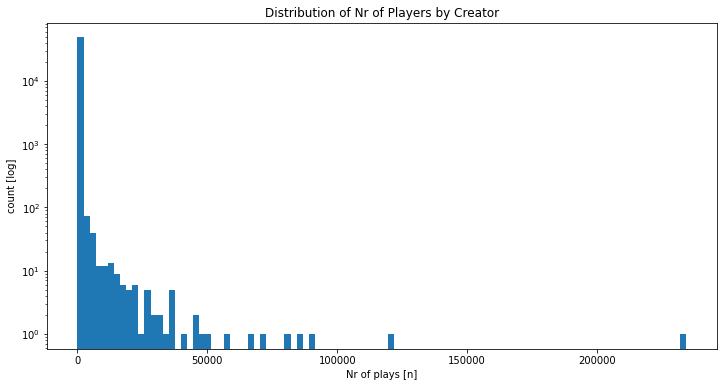

In [54]:
def cleanse_course_meta(course_meta):
    """Keeps just the last entry of course_meta catches per course id"""
    course_meta['catch'] = pd.to_datetime(course_meta['catch'])
    course_meta = course_meta.sort_values(by=['id','catch'])
    course_meta_cleansed = course_meta.groupby(by='id').last().reset_index()
    return course_meta_cleansed

cleanse_course_meta = cleanse_course_meta(course_meta)
df_top_creators = rank_creators(courses, cleanse_course_meta, "players")

plt.figure(figsize=(12, 6))
plt.hist(df_top_creators["players"], bins = 100)
plt.yscale("log")
plt.title("Distribution of Nr of Players by Creator")
plt.xlabel("Nr of plays [n]")
plt.ylabel("count [log]")
plt.show()

Im Histogramm ist zu erkennen, dass der grösste Teil der Creators keine oder nur sehr wenige Spieler auf den eigens veröffentlichten Levels hat. Es scheint offenbar auch ein Spieler zu geben, welcher mit seinen Levels mit Abstand die grösste Anzahl an Spielern erreicht hat.

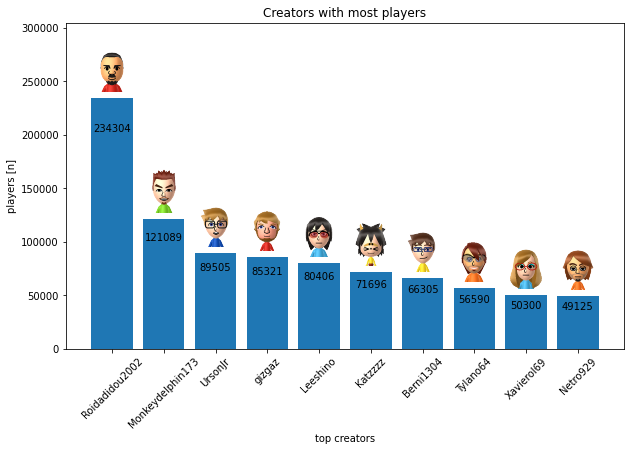

In [55]:
top_creators_bar(df_top_creators, "players", 10, players)

Die Visualisierung zeigt die Creators, welche über alle erstellten Levels am meisten Spieler hatten. Der Creator Roidadidou2002 hat mit 234'304 Spielerinteraktionen (was 5.9 Prozent aller Spiele im Datensatz entspricht) deutlich am meisten Spieler erreicht. Der zweitplatzierte Monkeydelphin173 erreicht mit 121'089 Spielern noch etwas mehr als die Hälfte verglichen mit dem ersten Platz. Alle anderen Profile erreichen weniger als 100'000 Spieler. 

### Most Stars

Wenn einem Spieler ein Level besonders gut gefällt, kann er diesem einen Stern hinterlassen. Wir möchten deshalb auch wissen welche Level-Ersteller die meisten Sterne/Likes haben. 

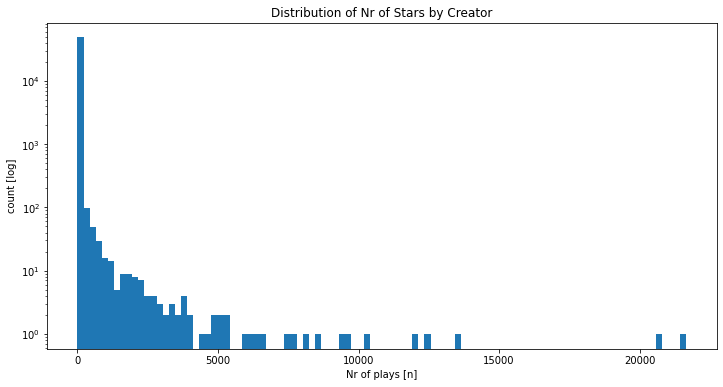

In [56]:
plt.figure(figsize=(12, 6))
plt.hist(df_top_creators["stars"], bins = 100)
plt.yscale("log")
plt.title("Distribution of Nr of Stars by Creator")
plt.xlabel("Nr of plays [n]")
plt.ylabel("count [log]")
plt.show()

Im Histogramm ist zu erkennen, dass zwei Profile deutlich mehr Sterne erhalten haben, als die anderen Creators. Die meisten Spieler haben 0 oder 1 Stern.

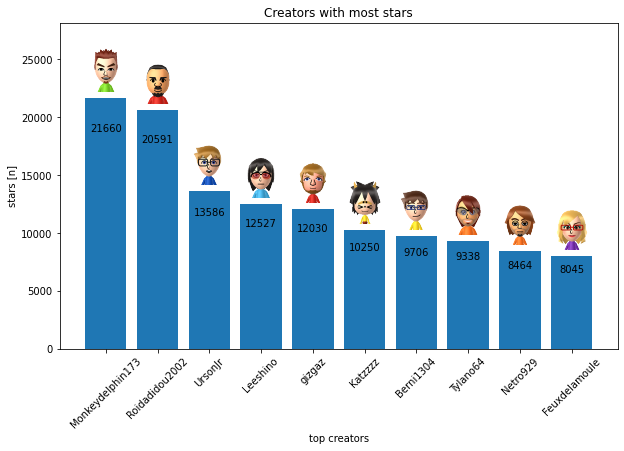

In [57]:
top_creators_bar(df_top_creators, "stars", 10, players)

Die Reihenfolge der Bestplatzierten beinhaltet mehrheitlich die gleichen top-platzierten Creators wie die Platzierung nach Anzahl Spieler.
Der Creator mit 21'660 Sternen ist Monkeydelphin173. Der zuvor erstplatzierte Roidadidou2002 erreicht mit 20'951 Sternen den zweiten Platz und hat verglichen mit den anderen Creators an Vorsprung verloren. Das Play-Like Verhältnis scheint hier also weniger hoch zu sein als bei den anderen führenden Creators.

### Most Levels

Zum Schluss wollen wir noch herausfinden, welche Spieler quantitativ am meisten Levels veröffentlicht haben.

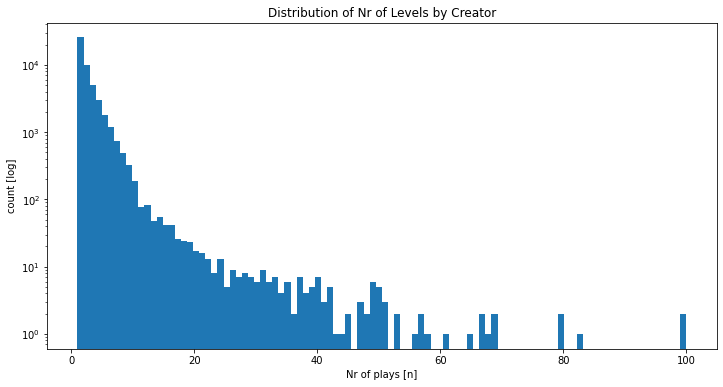

In [58]:
plt.figure(figsize=(12, 6))
plt.hist(df_top_creators["levels"], bins = 100)
plt.yscale("log")
plt.title("Distribution of Nr of Levels by Creator")
plt.xlabel("Nr of plays [n]")
plt.ylabel("count [log]")
plt.show()

Die Verteilung in der Anzahl an erstellten Levels ist weniger stark zu streuen als bei den Spielern und den Sternen. Im Histogramm sind jedoch nur die 20 Prozent der Profile enthalten, welche ein Level veröffentlicht haben.

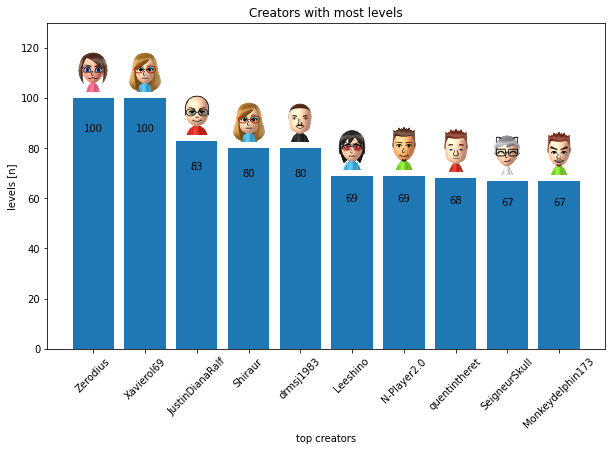

In [59]:
top_creators_bar(df_top_creators, "levels", 10, players)

Die beiden besten Accounts, mit den Spitznamen Zerodius und Xavierol69, haben beide je 100 Levels erschaffen. Es fällt auf, dass nur 5 Creators im Datensatz über 70 Levels erstellt haben. Das ist unter anderem dadurch zu erklären, dass die eigentliche Obergrenze an aktiven veröffentlichten Levels pro Account bei 64 Levels festgesetzt ist. Creators welche über dieser Zahl sind (also alle hier enthaltenen) mussten entsprechend Zwangsläufig einen Teil ihrer Levels wieder löschen, bevor sie weitere erschufen.

### Zusammenfassung

Über alle Profile im Datensatz haben 20 Prozent schon mindestens ein Level veröffentlicht. Es gibt einen kleinen Anteil an Creators, welchen einen grossen Teil der Spiele zugeschrieben werden kann. So haben die Levels der 10 Creators mit den meisten Spielen total 904641 Interaktionen was gut 22.9 Prozent der 3941379 Spielinteraktionen des gesamten Datensatzes ausmacht. Diese "Top-Creators" sind für das Netzwerk also von sehr hoher Wichtigkeit und es ist für Nintendo ratsam diese Möglichst aktiv zu halten, z.B. indem die maximal erlaubte Anzahl an veröffentlichten Levels pro Spieler erhöht wird.

## Clears Analyse

Ein Clear beschreibt das erfolgreiche Beenden des Levels eines Spielers. Als erstes erstellen wir den Graph anhand der .csv Files. Die Edges erhalten wir durch die Schnittmenge der drei Tabellen `players`, `clears` und `courses`.

In [60]:
def create_graph(source, connection, target):
    first_merge = source.merge(connection, left_on='id', right_on='player', how='inner')
    second_merge = first_merge.merge(target, left_on='id_y', right_on='id', how='inner')
    edges = pd.DataFrame({
            "source": second_merge['player'],
            "target": second_merge['id']
        })
    
    G = nx.from_pandas_edgelist(edges, create_using=nx.Graph())
    return edges, G

edges_clears, G_clears = create_graph(players, clears, courses)

### Top 10 geclearte Levels

Wir schauen zuerst die 10 meistgeclearten Levels und deren Spieler an um eine Vorstellung von deren Grösse und Spielerbasis zu haben. Zu sehen sind dann als rote Punkte die Levels, welche durch die Spieler (blaue Punkte) gecleart wurden dargestellt als Two-Mode Netzwerk.

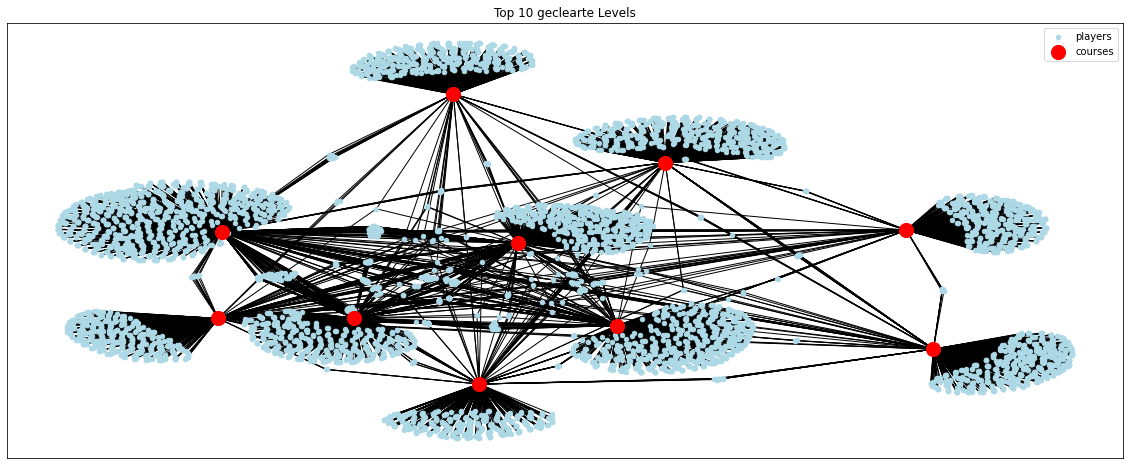

In [61]:
top_10_level_clears = edges_clears.groupby(by='target').count().reset_index().sort_values(by='source').iloc[-10:,:]['target']
top_10_level_edges = edges_clears[edges_clears['target'].isin(top_10_level_clears)]
G_top_10_level_clears = nx.from_pandas_edgelist(top_10_level_edges, create_using=nx.Graph())

plt.figure(figsize=(20,8))
pos = nx.drawing.layout.spring_layout(G_top_10_level_clears, seed = 42)
nx.draw_networkx_nodes(G_top_10_level_clears, pos, nodelist=top_10_level_edges['source'].unique(), node_size=20, node_color="lightblue", label='players')
nx.draw_networkx_nodes(G_top_10_level_clears, pos, nodelist=top_10_level_edges['target'].unique(), node_size=200, node_color="red", label='courses')
nx.draw_networkx_edges(G_top_10_level_clears, pos)
plt.title('Top 10 geclearte Levels')
plt.legend()
plt.show()

In [62]:
print(nx.info(G_top_10_level_clears))

Name: 
Type: Graph
Number of nodes: 6287
Number of edges: 7070
Average degree:   2.2491


Die meisten Spieler haben nur eines dieser Levels durchgespielt, was an den blauen Klumpen zu erkennen ist. Wahrscheinlich fürt die grosse Levelvielfalt zu dieser geringen Vernetzung der top 10 Levels unter den Spielern.<br><br>

Als nächstes schauen wir uns die gemeinsamen Spieler der Top 10 Levels an, um herauszufinden, wie die Levels bezüglich Spielerbasis zusammenhängen. Dies kann bewerkstelligt werden, in dem das vorherige Top 10 Level Netzwerk bezüglich clears von einem Two-Mode in ein One-Mode Netzwerk porjeziert wird, und die Anzahl gemeinsamen Verbindungen das Kantengewicht darstellt. Die Labels der 10 wichtigsten Levels werden nicht angezeigt, da das Anzeigen der ID keinen Mehrwert generiert.

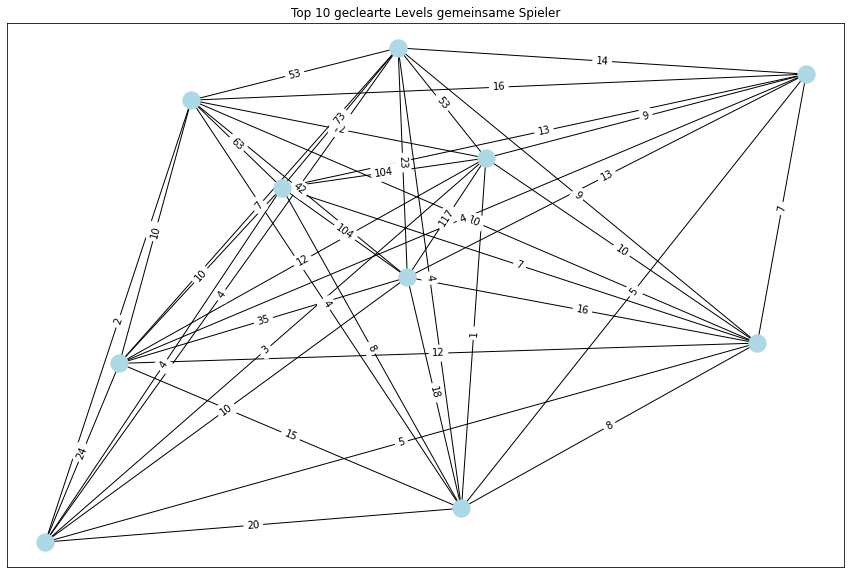

In [63]:
def draw_emphasizing_edge_weight(G, title=None, seed=42):
    plt.figure(figsize=(15,10))
    pos = nx.drawing.layout.spring_layout(G, seed=seed)
    
    nx.draw_networkx_nodes(G, pos, node_color="lightblue")
    nx.draw_networkx_edges(G, pos)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    plt.title(title)
    plt.show()
        
G_top_10_level_clears_first_group, G_top_10_level_clears_second_group = bipartite.sets(G_top_10_level_clears)
wp_G_top_10_level_clears = bipartite.weighted_projected_graph(G_top_10_level_clears, G_top_10_level_clears_second_group)
draw_emphasizing_edge_weight(wp_G_top_10_level_clears, title='Top 10 geclearte Levels gemeinsame Spieler', seed=39)

In [64]:
print(nx.info(wp_G_top_10_level_clears))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 44
Average degree:   8.8000


Der Graph zeigt gemeinsame Spielerbasen von keine gemeinsamen Spieler bis 117 gemeinsame Spieler. Ein kleiner Teil der Levels (Gewicht > 50) scheint stärker durch die Spieler verknüpf zu sein als der Rest.<br><br>

### Statistik Plays & Clears

Uns interessiert nun, ob es zwischen den Beziehungen Korrelationen gibt. 

**Plays & Clears**

Als erstes untersuchen wir den linearen Zusammenhang zwischen den Anzahl plays (angespielte Levels) und clears.

In [65]:
plays_count = plays.groupby(by='player').agg('count').rename(columns={'catch':'plays'})[['plays']].reset_index()
clears_count = clears.groupby(by='player').agg('count').rename(columns={'catch':'clears'})[['clears']].reset_index()
likes_count = likes.groupby(by='player').agg('count').rename(columns={'catch':'likes'})[['likes']].reset_index()

plays_clears = plays_count.merge(clears_count, on='player')
likes_clears = likes_count.merge(clears_count, on='player')

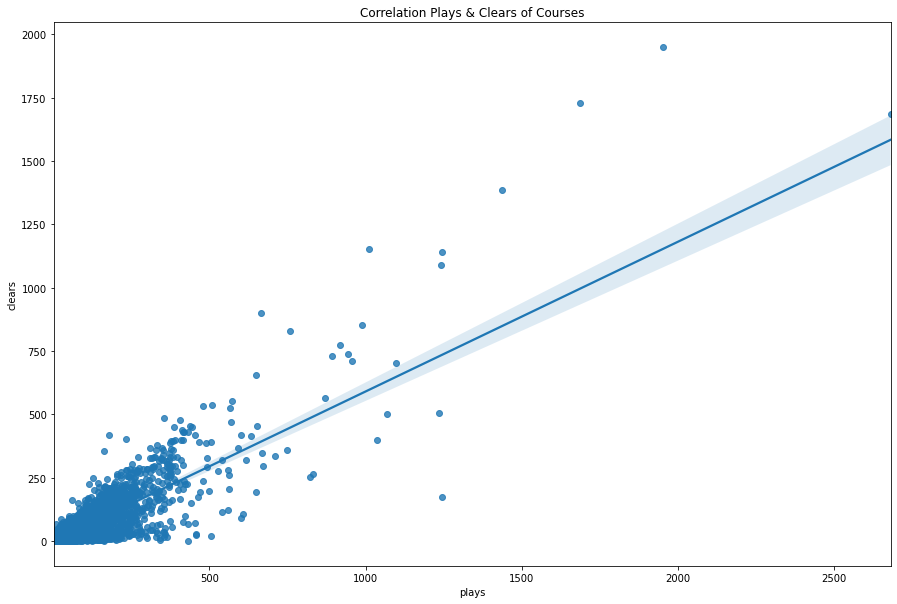

In [66]:
_ = plt.figure(figsize=(15,10))
_ = sns.regplot(x='plays', y='clears', data=plays_clears)
_ = plt.title('Correlation Plays & Clears of Courses')

In [67]:
plays_clears_pearson = plays_clears['plays'].corr(plays_clears['clears'], method='pearson')
plays_clears_pearson

0.879007154220985

Der Pearson Korrelationskoeffizient von $\approx$ 0.88 zeigt, dass die Anzahl angespielten Levels (plays) sehr stark mit den Anzahl geschafften Levels (clears) linear zusammenhängen. Die starke Korrelation ist nicht überraschend aufgrund der Natur der Sache, da ein Clear nur stattfinden kann wenn ein Play stattgefunden hat. Es besteht also eine direkte Abhängigkeit zwischen Clears und Plays.<br><br>

**Liked & Cleared**

Weniger offensichtlich ist es, ob ein Like einen Zusammenhang hat, ob man ein Level geschafft hat oder nicht unter einem Signifikanzniveau von 99% ($\alpha$ = 0.01). Da beide Variablen nominal skaliert sind, kommt der Chi$^2$ Test zur Anwendung.<br>
$H_0$: Es gibt KEINEN Unterschied bezüglich einem Like und ob man ein Level geschafft hat oder nicht<br>
$H_A$: Es gibt einen Unterschied bezüglich einem Like, ob man ein Level geschafft hat oder nicht

In [68]:
from scipy.stats import chi2_contingency

plays_likes = plays.merge(likes, on=['id','player'], how='left')
plays_likes['like'] = plays_likes['catch_y'].notna()
plays_likes = plays_likes[['id','player','like']]
plays_likes_clears = plays_likes.merge(clears, on=['id','player'], how='left')
plays_likes_clears['clear'] = plays_likes_clears['catch'].notna()
plays_likes_clears = plays_likes_clears[['id','player','like','clear']]

like_clear = plays_likes_clears[(plays_likes_clears['like'] == True) & (plays_likes_clears['clear'] == True)].shape[0]
likenot_clear = plays_likes_clears[(plays_likes_clears['like'] == False) & (plays_likes_clears['clear'] == True)].shape[0]
like_clearnot = plays_likes_clears[(plays_likes_clears['like'] == True) & (plays_likes_clears['clear'] == False)].shape[0]
likenot_clearnot = plays_likes_clears[(plays_likes_clears['like'] == False) & (plays_likes_clears['clear'] == False)].shape[0]

contingency_table = np.array([[like_clear,likenot_clear],[like_clearnot,likenot_clearnot]])
chi2, p, dof, ex = chi2_contingency(contingency_table)

Hier zu sehen ist die Kontingenztabelle. Hier lässt sich bereits erahnen, dass es eine Abhängigkeit gibt, da mehr Spieler ein Level Like gemacht haben, wenn sie ein Level geschafft haben und mehr Spieler kein Like gemacht haben, wenn sie das Level nicht geschafft haben.

In [69]:
mi_liked = pd.MultiIndex.from_arrays([['liked']*2, [True,False]])
mi_cleared = pd.MultiIndex.from_arrays([['cleared']*2, [True,False]])
print('Kontingenztabelle')
pd.DataFrame(data=contingency_table, columns=mi_liked, index=mi_cleared)

Kontingenztabelle


liked         
                True     False
cleared True   333180  1571850
        False  101732  1934616

Hier sind die erwarteten Häufigkeiten der Kontingenztabelle zu sehen, wenn es keine Abhängigkeit zwischen den Variablen geben würde.

In [70]:
print('Erwartete Häufigkeiten')
pd.DataFrame(data=ex, columns=mi_liked, index=mi_cleared)

Erwartete Häufigkeiten


liked              
                       True          False
cleared True   210210.846907  1.694819e+06
        False  224701.153093  1.811647e+06

Nun schauen wir uns den P-Wert des Chi$^2$ Tests an.

In [71]:
p

0.0

Da der p < $\alpha$, d.h. 0.0 < 0.01, müssen wir die $H_0$ ablehnen. Es gibt also einen Unterschied, bezüglich der Anzahl Likes, ob der Spieler/in ein Level geschafft hat. Das heisst, Personen, welche ein Level geschafft haben, Liken ein Level häufiger, als wenn sie es nicht geschafft haben.<br>

## Link Prediction Players & Plays

Nun versuchen wir, eine Link-Prediction auf dem Datensatz bezüglich welche Spieler welches Level als nächstes spielen wird. Wir haben hier die Situation, dass wir ein two-mode Netzwerk haben. Die im Skript besprochenen Algorithmen beziehen sich ausschliesslich auf one-mode Netzwerke. Natürlich könnten wir das two-mode Netzwerk in ein one-mode umwandeln. Dadurch würden wir jedoch lediglich die Spieler, oder die Levels miteinander verbinden. Unser Ziel ist jedoch, Spielern ein Level vorzuschlagen, welches sie noch nicht benutzt haben.

Ein einfacher Ansatz wäre es, einer Community diejenigen Levels vorzuschlagen, welche von Spielern dieser Community gespielt wurden, sie selbst jedoch nocht nicht gespielt haben. Dies ist jedoch ein sehr aufwendiger Prozess, welcher immer wieder neu evaluiert und berechnet werden muss. Deswegen haben wir uns für einen anderen Ansatz entschieden. 

Ein two-mode Netzwerk kann auch als Adjazenzmatrix interpretiert werden, bei dem die Reihen die Spieler und die Kolonnen die Levels beinhaltet. Damit haben wir eine Player-Level Interaktionsmatrix. Predictions können in diesem Kontext auch als Recommendations interpretiert werden. Eine relativ bekannte Technik für Recommendations auf einer Interaktionsmatrix ist die Singulärwertzerlegung (SVD) der Matrix, mit einer anschliessenden Rekonstruktion, wobei nur $k$ Singulärwerte für die Rekonstruktion verwendet werden. Ein Vorteil dieses Verfahrens ist, dass für neue Spieler mit einer sogenannten *folding-in* Technik (Sarwar et al., 2002) sehr einfach und kostengünstig (bezüglich Rechenkapazität) Recommendations, also Predictions gemacht werden können. Die Prediction machen wir auf den Level-ID's. Ein späteres Matching mit dem Levelnamen wäre problemlos möglich, ist jedoch für diese Aufgabe nicht nötig.

**Quelle**

Sarwar, B., Karypis, G., Konstan, J., & Riedl, J. (2002). Incremental singular value decomposition algorithms for highly scalable recommender systems. Fifth international conference on computer and information science, 1(012002), 27–28.

### Level & Spieler Reduktion

Ein Problem der SVD ist, dass wir theoretisch eine Interaktionsmatrix von mehr als 800'000 Spielern mit mehr als 100'000 Leveln hätten. Dies ist eine viel zu Rechenintensive zerlegung, weshalb wir die Levels und Spieler vorfiltern.

Zuerst reduzieren wir die Anzahl Levels, in dem wir die 8000 am meisten gespielten Levels nehmen. Es ist wichtig, zuerst die Levels vor den Spielern zu filtern, damit wie bei den Spielern auch garaniteren können, dass diese noch vorhandene Levels gespielt haben. Es macht ja keinen Sinn, Links predicten zu wollen bei Spielern, welche keine bekannte Connection zu einem Level haben. `top_plays_levels` beinhaltet die 8000 am meisten gespielten Levels und `plays_red` beinhaltet die Player-Level Interaktionen der Top 8000 Levels.

In [72]:
plays_level_count = plays.groupby(by='id').agg('count').rename(columns={'catch':'plays'})[['plays']].reset_index()
top_plays_levels = plays_level_count.sort_values(by='plays', ascending=False).iloc[:8000].reset_index(drop=True)
top_plays_levels

id  plays
0     5AB9-0000-038F-A23E   1673
1     F44D-0000-035E-496C   1143
2     DE4D-0000-035D-3AE1   1089
3     A4E1-0000-038D-0EBC   1021
4     8F40-0000-0391-4B50   1014
...                   ...    ...
7995  3204-0000-033C-74FA     74
7996  4DD9-0000-032F-5323     74
7997  47E5-0000-032B-92FD     74
7998  4C5A-0000-036A-902D     74
7999  012E-0000-030C-8A7D     74

[8000 rows x 2 columns]

In [73]:
plays_red = plays[plays['id'].isin(top_plays_levels['id'])]
plays_red

catch                   id       player
570     2018-01-31 14:38:02.804  000E-0000-0331-2D8D      rui0987
663     2017-12-18 14:48:02.654  000E-0000-0331-2D8D      0111hiy
664     2017-12-18 14:48:02.654  000E-0000-0331-2D8D   akibo-0915
665     2017-12-18 14:48:02.654  000E-0000-0331-2D8D  alexisp2005
666     2017-12-18 14:48:02.654  000E-0000-0331-2D8D  aomitsu2180
...                         ...                  ...          ...
3941296 2018-03-02 10:08:07.374  FFFC-0000-0346-165A     yuji1333
3941297 2018-03-02 10:08:07.374  FFFC-0000-0346-165A    yuuna2010
3941298 2018-03-02 10:08:07.374  FFFC-0000-0346-165A   YvetteMack
3941299 2018-03-02 10:08:07.374  FFFC-0000-0346-165A     ZGAMER18
3941300 2018-03-02 10:08:07.374  FFFC-0000-0346-165A  Zurix_Maker

[864189 rows x 3 columns]

Schliesslich müssen wir noch die Spieler Filtern, welche mit den verbleibenden 8000 Levels am Meisten Interaktionen hatten. `plays_player_count` beinhaltet diese 10000 Spieler und `plays_top_levels_players` repräsentiert die Level-Spieler Interaktionen der Top 8000 Levels und der Top 10000 Spieler bezüglich "Level gespielt".

In [74]:
plays_player_count = plays_red.groupby(by='player').agg('count').rename(columns={'catch':'plays'})[['plays']].reset_index()
top_plays_players = plays_player_count.sort_values(by='plays', ascending=False).iloc[:10000].reset_index(drop=True)
top_plays_players

player  plays
0     Conducteur59220    746
1     Plusbellelavie5    746
2       Feuxdelamoule    599
3          cowboye123    576
4          indien1966    496
...               ...    ...
9995      Adam-Damian     10
9996     hiroto-yuuga     10
9997        Axepick06     10
9998    FarmerRobison     10
9999   stevegeorgebay     10

[10000 rows x 2 columns]

In [75]:
plays_top_levels = plays[plays['id'].isin(top_plays_levels['id'])]
plays_top_levels_players = plays_top_levels[plays_top_levels['player'].isin(top_plays_players['player'])].reset_index(drop=True)
plays_top_levels_players['play'] = 1
plays_top_levels_players

catch                   id           player  play
0      2017-12-18 14:48:02.654  000E-0000-0331-2D8D           arti81     1
1      2017-12-18 14:48:02.654  000E-0000-0331-2D8D      bulldog1979     1
2      2017-12-18 14:48:02.654  000E-0000-0331-2D8D   CardcaptorGirl     1
3      2017-12-18 14:48:02.654  000E-0000-0331-2D8D  Conducteur59220     1
4      2017-12-18 14:48:02.654  000E-0000-0331-2D8D        Doddsyctd     1
...                        ...                  ...              ...   ...
236059 2018-03-02 10:08:07.374  FFFC-0000-0346-165A         TechOWeb     1
236060 2018-03-02 10:08:07.374  FFFC-0000-0346-165A       TOOKOOL614     1
236061 2018-03-02 10:08:07.374  FFFC-0000-0346-165A       YvetteMack     1
236062 2018-03-02 10:08:07.374  FFFC-0000-0346-165A         ZGAMER18     1
236063 2018-03-02 10:08:07.374  FFFC-0000-0346-165A      Zurix_Maker     1

[236064 rows x 4 columns]

### SVD Model

Nun erstellen wir die Interaktionsmatrix, welche als `user_play_matrix` repräsentiert wird. `levelIdx_levelId` sieht eine Übersetzung des Matrixindexes der Levels zu den Level-Ids vor. Nun gilt es herauszufinden, welches $k$ wir verwenden wollen für die Rekonstruktion. SVD ist definiert als: $A = U\Sigma V^T$, wobei $\Sigma$ eine Diagonalmatrix mit den Singulärwerten rsp. den Wurzeln der Eigenwerte von $A^T A$ oder $A A^T$ sind. Wenn $A \in \mathbb{R}^{10000 \times 8000}$, dann kann $A$ mit $U \in \mathbb{R}^{10000 \times k}$, $\Sigma \in \mathbb{R}^{k \times k}$ und $V \in \mathbb{R}^{k \times 8000}$, approximiert werden, wobei $k$ die Anzahl Singulärwerte sind.

In [76]:
df_user_play_matrix = plays_top_levels_players.pivot(index='player', columns='id', values='play')
df_user_play_matrix = df_user_play_matrix.fillna(0)
levelIdx_levelId = {level_idx:level_id for level_idx, level_id in enumerate(df_user_play_matrix.columns)}
user_play_matrix = df_user_play_matrix.to_numpy()

Nun müssen wir $k$ definieren. Eigentlich ist dies ein Hyperparameter des SVD Models. Da wir aus Zeitgründen jedoch keine Evaluation mittels einer Zielmetrik vornehmen, versuchen wir, $k$ mittels der Visualisierung der Singulärwerte abzuschätzen. Optimalerweise haben wir eine elbogenförmige Form der Singulärwerte, wobei wir dann $k$ nahe an diesem Bogen wählen können.

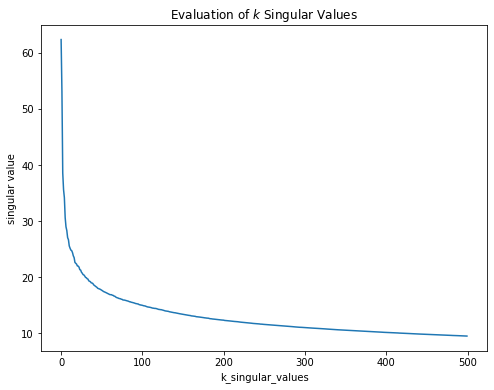

In [77]:
U_eval, s_eval, V_eval = scipy.sparse.linalg.svds(csc_matrix(user_play_matrix), k=500)

top_500_singular_values = np.sort(s_eval)[::-1]
_ = plt.figure(figsize=(8, 6))
_ = plt.plot(top_500_singular_values)
_ = plt.xlabel('k_singular_values')
_ = plt.ylabel('singular value')
_ = plt.title('Evaluation of $k$ Singular Values')

Die sträkste Beugung ist bei ca. 30-40 Singulärwerten zu beobachten. Wir wählen konservativ leicht mehr Singulärwerte, damit die Approximation ein bisschen besser wird.

### SVD Prediction

Nun erstellen wir das SVD Model mit 50 Singulärwerten, und rekonstruieren die Interaktonsmatrix anschliessend in `reconstruction`. Anschliessend müssen wir alle Werte, welche in der Orginalen Interaktionsmatrix `user_play_matrix` auf 1 gesetzt waren auf 0 setzen, damit nicht schon bisherig gespielte Levels als Prediction vorgeschlagen werden. Dies erreichen wir mit einer Matrix `user_play_matrix_remove_ones` , welche die gleiche Dimension hat wie `user_play_matrix` und überall aus 1 besteht, ausser da, wo bei `user_play_matrix` 1 war (da setzen wir die Werte auf 0). Anschliessend können wir die beiden Matrizen miteinander elementweise Multiplizieren, damit die bisherigen Levels auf 0 gesetzt werden, und damit nicht mehr in der Prediction vorkommen. Das Resultat wird in `user_play_predictions` gespeichert.

In [78]:
U, s, Vt = scipy.sparse.linalg.svds(csc_matrix(user_play_matrix), k=50)
reconstruction = (U @ np.diag(s)) @ Vt

In [79]:
upm_idx1 = np.where(user_play_matrix == 1) # indexes where play was 1 to set to 0
user_play_matrix_remove_ones = np.ones(user_play_matrix.shape) # matrix initialisation to elementwise multiply with ones except `upm_idx1` to remove previous plays
user_play_matrix_remove_ones[upm_idx1] = 0
user_play_predictions = reconstruction * user_play_matrix_remove_ones

Nun haben wir eine Approximation der Interaktonsmatrix, welche die wesentliche Struktur noch einigermassen beibehalten hat. Somit haben wir eine neue Adjazenzmatrix mit Noise und ohne die bisherigen Verbindungen. Es verbleibt nur noch, die Link Prediction zu machen, also, welcher Spieler welches Level als nächstes spielt. Dafür holen wir pro Spieler die Indizes der 10 grössten Werte (top 10 Prediction) heraus. Diese werden in `top_n_idx` gespeichert. Anschliessend kann mittels `levelIdx_levelId` vom Index auf das Level geschlossen werden.

In [80]:
top_n = 10
top_n_idx = np.argpartition(user_play_predictions, -top_n, axis=1)[:,-top_n:]
top_n_idx

array([[5794, 7768,  248, ..., 1589,  331, 5787],
       [7524, 3878,  544, ..., 1059, 7782, 3008],
       [3150, 2463,  128, ...,  248, 4145, 3725],
       ...,
       [3860, 7768, 1579, ..., 2730, 6237, 7493],
       [6310,  448, 4839, ..., 5083, 1261, 6800],
       [3028, 2201, 3572, ..., 1965, 1955, 4249]], dtype=int64)

In [81]:
levelIdx_levelId[top_n_idx[0,0]]

'BB01-0000-0361-084F'

Aus Zeitgründen haben wir auf eine Evaluation verzichtet. Wir denken trotzdem, dass dies ein wahrscheinlich guter weg ist, um eine Link-Prediction in einem two-mode Netzwerk vorzunehmen.

## Ausblick

Ansätze der Sozialen Netzwerkanalyse verbunden mit Themen von Recommender Systemen erlauben es Levels zu bestimmen welche einem Benutzer gefallen könnten. Anhand von Cliques könnten einem Spieler Levels empfohlen werden die in seiner näheren Umgebung beliebt sind (Siehe Kapitel "Recommending levels based on cliques"). Im Kapitel "Link Prediction Players & Plays" sehen wir wie in einem Two-Mode Netzwerk Link Prediction verwendet werden kann. Dadurch haben wir eine weitere Methode um einem Spieler Levels oder ähnliche Spieler vorzuschlagen. 

Basierend auf unseren Resultaten können wir uns mehrere Features vorstellen die von der Plattform implementiert werden könnten:

- 'Player Recommendation': Einem Spieler werden andere Spieler vorgeschlagen die ähnliche "Interessen" aufweisen, sprich die selben Levels gespielt haben oder in der selben Clique sind.
- 'Level Recommendation': Einem Spieler werden neue levels Vorgeschlagen. Mehrere Faktoren könnten in diese Liste mit einfliessen: Fähigkeiten des Spielers (welches Schwierigkeitsniveau hat er erreicht), Levels die in der lokalen Clique gespielt werden, Allgemein beliebte Levels (falls der Spieler noch nicht aktiv war (Cold Start Problem)), Levels von ähnlichen Spieleren (SVD). 
- 'Community Service': Spieler könnten eine Community bilden (im Game Jargon: "ein Klan"). Ihm könnten die Mitglieder der lokalen Clique als potenzielle Community-Mitglieder empfohlen werden.
- "Oft zusammen gespielt": Ein Feature welches Levels empfiehlt welche oft zusammen gespielt werden. Siehe Amazon-Feature "Oft zusammen gekauft".
- "Top Players": Ein erstelltes Ranking von Players basierend auf Level Interaktionen gibt das eigene Ranking an sowie die Top Players.